# CMIP6 Regression and Driver Analysis

### Import Packages

In [4]:
# ========== Packages ==========
import xarray as xr
import pandas as pd
import numpy as np
import os
import copy
import glob
import sys
import importlib

# Processing
import dask
from dask.diagnostics import ProgressBar
import math
import multiprocessing as mp
import regionmask

# Statistics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr, kendalltau, variation, gaussian_kde, skew, kurtosis, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, ParameterGrid, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# For plotting
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import seaborn as sns

import matplotlib.cm
from matplotlib import rcParams
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# For color map
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

# Define the full path to the needed directories
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
data_analysis_dir = '/work/ch0636/g300115/phd_project/common/src/analysis'
data_vis_dir = '/work/ch0636/g300115/phd_project/common/src/visualization'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(data_analysis_dir)
sys.path.append(data_vis_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as load_dat
import process_data as pro_dat
import compute_statistics as comp_stats
import regression_analysis as reg_analysis
import regression_analysis_plots as reg_plots
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

%matplotlib inline

rcParams["mathtext.default"] = 'regular'

In [5]:
# Reload functions if changed
importlib.reload(comp_stats)
importlib.reload(pro_dat)
importlib.reload(reg_analysis)
importlib.reload(reg_plots)

<module 'regression_analysis_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/regression_analysis_plots.py'>

In [6]:
# Set pandas options to display the full DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Functions

### Scaling

In [7]:
def custom_scale(data):
    # Find the absolute maximum value in the data
    max_val = np.max(np.abs(data), axis=0)

    # Scale data by dividing by the max value
    scaled_data = data / max_val

    return scaled_data, max_val

In [8]:
def scale_data(X, method):
    scaler_data = {}

    if method == 'std':
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X)
        scaler_data = {'mean': scaler.mean_, 'std': scaler.scale_}

    elif method == 'minmax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_standardized = scaler.fit_transform(X)
        scaler_data = {'min': scaler.data_min_, 'max': scaler.data_max_}
        
    elif method == 'max':
        X_standardized, max_val = custom_scale(X)
        scaler_data = {'max': max_val}

    elif method == 'no_scaling':
        X_standardized = X
        
    else:
        raise ValueError('Scaling method not known')

    return X_standardized, scaler_data

In [9]:
def custom_scale(data):
    max_val = np.max(np.abs(data), axis=0)
    scaled_data = data / max_val
    return scaled_data, max_val

### Regression Analysis

#### Test Model

In [10]:
def plot_performance_metrics(performance_metrics_train, performance_metrics_test, cv_scores_r2, cv_scores_mse, cv_scores_r2_train, cv_scores_mse_train, cv_scores_r2_test, cv_scores_mse_test):
    regions = list(performance_metrics_train.keys())
    mse_train = [performance_metrics_train[region]['MSE'] for region in regions]
    mse_test = [performance_metrics_test[region]['MSE'] for region in regions]
    r2_train = [performance_metrics_train[region]['R2'] for region in regions]
    r2_test = [performance_metrics_test[region]['R2'] for region in regions]
   
    fig, ax = plt.subplots(6, 1, figsize=(15, 30))

    # Plot 1: R2 Comparison
    ax[0].plot(regions, r2_train, label='Train R2', marker='o')
    ax[0].plot(regions, r2_test, label='Test R2', marker='o')
    ax[0].set_title('R2 Comparison')
    ax[0].set_xlabel('Regions')
    ax[0].set_ylabel('R2')
    ax[0].set_ylim([0,1])
    ax[0].legend()
    ax[0].tick_params(axis='x', rotation=90)

    # Plot 2: MSE Comparison
    ax[1].plot(regions, mse_train, label='Train MSE', marker='o')
    ax[1].plot(regions, mse_test, label='Test MSE', marker='o')
    ax[1].set_title('MSE Comparison')
    ax[1].set_xlabel('Regions')
    ax[1].set_ylabel('MSE')
    ax[1].set_ylim([0,0.006])
    ax[1].legend()
    ax[1].tick_params(axis='x', rotation=90)

    # Function to plot mean or standard deviation
    def plot_cv_scores(ax, cv_scores_whole, cv_scores_train, cv_scores_test, title, ylabel):
        means_whole = [np.mean(scores) for scores in cv_scores_whole]
        means_train = [np.mean(scores) for scores in cv_scores_train]
        means_test = [np.mean(scores) for scores in cv_scores_test]
        if ylabel == 'Mean Scores':
            ax.plot(regions, means_whole, label='Whole Data', marker='o')
            ax.plot(regions, means_train, label='Train Data', marker='o')
            ax.plot(regions, means_test, label='Test Data', marker='o')
        else:
            stds_whole = [np.std(scores) for scores in cv_scores_whole]
            stds_train = [np.std(scores) for scores in cv_scores_train]
            stds_test = [np.std(scores) for scores in cv_scores_test]
            ax.plot(regions, stds_whole, label='Whole Data', marker='o')
            ax.plot(regions, stds_train, label='Train Data', marker='o')
            ax.plot(regions, stds_test, label='Test Data', marker='o')
        
        # Set y-axis limits for R2 plots
        if title == 'Mean CV R2 Scores' or title == 'Std CV R2 Scores':
            ax.set_ylim([0, 1]) 
        else:
            ax.set_ylim([0, 0.006]) 

        ax.set_title(title)
        ax.set_xlabel('Regions')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.tick_params(axis='x', rotation=90)

    # Plot 3: Mean CV R2 Scores
    plot_cv_scores(ax[2], [cv_scores_r2[region] for region in regions], [cv_scores_r2_train[region] for region in regions], [cv_scores_r2_test[region] for region in regions], 'Mean CV R2 Scores', 'Mean Scores')

    # Plot 4: Std CV R2 Scores
    plot_cv_scores(ax[3], [cv_scores_r2[region] for region in regions], [cv_scores_r2_train[region] for region in regions], [cv_scores_r2_test[region] for region in regions], 'Std CV R2 Scores', 'Standard Deviation')

    # Plot 5: Mean CV MSE Scores
    plot_cv_scores(ax[4], [cv_scores_mse[region] for region in regions], [cv_scores_mse_train[region] for region in regions], [cv_scores_mse_test[region] for region in regions], 'Mean CV MSE Scores', 'Mean Scores')

    # Plot 6: Std CV MSE Scores
    plot_cv_scores(ax[5], [cv_scores_mse[region] for region in regions], [cv_scores_mse_train[region] for region in regions], [cv_scores_mse_test[region] for region in regions], 'Std CV MSE Scores', 'Standard Deviation')

    plt.tight_layout()
    plt.show()

### Driver Analysis

In [11]:
def plot_permutation_importances(permutation_importances, predictor_vars, performance_metrics, split='test', season='Year', save_fig=False):
    # Set larger font sizes
    plt.rcParams.update({'font.size': 24})
    
    # Get variable names and prepare them for display
    var_names = prepare_display_variables(predictor_vars)

    for region in permutation_importances:
        # Convert arrays to DataFrame for easy plotting, applying new variable names for display
        df = pd.DataFrame(permutation_importances[region].T, columns=predictor_vars)
        df.rename(columns=var_names, inplace=True)
        
        # Create the plot for the region
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.boxplot(data=df, orient='h', ax=ax)
        ax.axvline(0, color='grey', linestyle='--')
        
        # Title with region
        ax.set_title(f'{region}')
        
        # Add Mean Squared Error and R-squared as text within the plot
        mse = round(performance_metrics[region]['MSE'], 4)
        r2 = round(performance_metrics[region]['R2'], 2)
        ax.text(0.95, 0.01, f'Mean Squared Error: {mse}\nR$^2$: {r2}',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes,  # Position text relative to axes
                color='black', fontsize=26)
        
        ax.set_xlabel('Decrease in Accuracy Score')

        plt.tight_layout()
        plt.show()
        
        if save_fig:
            save_figure(fig, region, split, season)

In [12]:
def prepare_display_variables(variables):
    var_map = {
        'tas': ('T', '°C'),
        'vpd': ('VPD', 'hPa'),
        'gpp': ('GPP', r'\frac{\frac{gC}{m^2}}{day}'),  
        'pr': ('P', r'\frac{mm}{day}'),
        'mrro': ('R', r'\frac{mm}{day}'),
        'evspsbl': ('ET', r'\frac{mm}{day}'),
        'tran': ('Tran', r'\frac{mm}{day}'),
        'evapo': ('E', r'\frac{mm}{day}'),
        'lai': ('Lai', r'\frac{m^2}{m^2}'),
        'mrso': ('SM', '\%'),
        'rgtr': ('P/T', r'\frac{GPP}{T}'),
        'et_partitioning': ('EP', r'\frac{E-Tran}{ET}'),
        'gsl': ('GSL', 'month'),
        'RX5day': ('RX5d', 'mm'),
        'wue': ('WUE', r'\frac{GPP}{Tran}'),
        'bgws': ('BGWS', r'\frac{R-Tran}{P}')
    }
    display_variables = {}
    for var in variables:
        if var in var_map:
            abbreviation, units = var_map[var]
            # Enclose units in \left[ and \right] for automatic sizing
            display_variables[var] = f"${{\Delta\, \mathrm{{\it{{{abbreviation}}}}}}}$"
        else:
            print(f"Variable '{var}' not found in var_map.")
            display_variables[var] = var  # Or handle this case as appropriate
    return display_variables

In [13]:
def save_figure(fig, region, split, season):
    # Caption and figure saving
    region_name = region.replace("/", "_")
    savepath = os.path.join('..', '..', 'results', 'CMIP6', 'historical-ssp370', 'time', 'mean', 'permutation_importance', season, split)
    os.makedirs(savepath, exist_ok=True)
    filename = f'{region_name}_permutation_importance_{split}_data_{season}.pdf'
    filepath = os.path.join(savepath, filename)
    fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    print(f'Figure saved under {filepath}')

## 1. Load and Preprocess

In [14]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical', 'ssp370']
models = ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']

variables=['pr', 'tran', 'mrro', 'vpd', 'mrso', 'lai', 'wue', 'gsl', 'RX5day'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(load_dat.load_period_mean(BASE_DIR, data_state, data_product, experiments, models, variables, specific_months_or_seasons=None))[0]

Loading 'month' resolution variables ['pr', 'vpd', 'tran', 'mrro', 'mrso', 'lai', 'wue'] for experiment 'historical'...
Selecting period 1985-2014 for 'month' variables in experiment 'historical'...
Computing period mean for 'month' variables in experiment 'historical'...
Loading 'year' resolution variable 'RX5day' for experiment 'historical'...
Computing period mean for 'year' variable in experiment 'historical'...
Loading 'period_mean' resolution variable 'gsl' for experiment 'historical'...
Merging all datasets for experiment 'historical'...
Loading 'month' resolution variables ['pr', 'vpd', 'tran', 'mrro', 'mrso', 'lai', 'wue'] for experiment 'ssp370'...
Selecting period 2071-2100 for 'month' variables in experiment 'ssp370'...
Computing period mean for 'month' variables in experiment 'ssp370'...
Loading 'year' resolution variable 'RX5day' for experiment 'ssp370'...
Computing period mean for 'year' variable in experiment 'ssp370'...
Loading 'period_mean' resolution variable 'gsl' f

In [15]:
ds_dict['historical'][list(ds_dict['historical'].keys())[3]]

<xarray.Dataset>
Dimensions:  (lat: 149, lon: 360)
Coordinates:
  * lat      (lat) int64 -59 -58 -57 -56 -55 -54 -53 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    pr       (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    vpd      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    tran     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    mrro     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    mrso     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    lai      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    wue      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    RX5day   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    gsl      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/70)
    Conventions:                      CF-1.7 CMIP-6.2
    description:                      CMIP6 historical
    title:                            CNRM-CM6-1 model output prepared for CM...
    activity_id:                      CMIP
    contact:                          contact.cmip@meteo.fr
    data_specs_version:               01.00.21
    ...                               ...
    intake_esm_attrs:time_min:        185001.0
    intake_esm_attrs:time_max:        201412.0
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.CNRM-CM6-1.historical.Amon.gr
    log:                              Dataset sliced along lat 60 to remove A...
    regrid_method:                    conservative

## 2. Compute Historical BGWS and Ensemble statsitics

In [16]:
ds_dict = pro_dat.compute_bgws(ds_dict)

In [17]:
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'mean')
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


In [18]:
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'mean')
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


## 3. Compute Changes and Ensemble statsitics

In [19]:
ds_dict_change = pro_dat.compute_change_dict(ds_dict)

Ensemble mean or median removed for keys: ['Ensemble mean', 'Ensemble median']


In [20]:
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'mean')
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


## 4. Divide Data into Regions and Subdregions

In [21]:
ds_dict_region = {}
ds_dict_region = pro_dat.apply_region_mask(ds_dict, with_global=True)

In [22]:
ds_dict_change_region = {}
ds_dict_change_region = pro_dat.apply_region_mask(ds_dict_change, with_global=True)

In [23]:
ds_dict_change_region_sub = {}
ds_dict_change_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                      ds_dict_change_region['ssp370-historical'], 'bgws')

## 5. Regression Analysis

In [24]:
# Reload function if changes have been applied
importlib.reload(reg_analysis)

<module 'regression_analysis' from '/work/ch0636/g300115/phd_project/common/src/analysis/regression_analysis.py'>

#### Regional Regression Analysis

In [25]:
# Define predictors and predictant
predictor_vars = ['pr', 'vpd', 'mrso', 'lai', 'wue', 'RX5day', 'gsl']  
predictant = 'bgws'
scaling_method = 'max' # None max
test_size = 0.2 # Share of the dataset used as test dataset (default is 0.3)
regression_type='elasticnet' # Regression technique (tested are ridge, lasso and elasticnet)
param_grid=None # Specify parameter grid here if different one to default should be used
grid_cell_threshold=50 # Define threshold for minimum grid cells per region
cv_folds=5 # define k for cross-validation (default is 5)
scoring='r2' # Scoring metric for Cross-Validation, default is r2.
evaluation_method='cv' # Method of evaluation ('test' or 'cv'), default is 'test'.
variable_importance_method='PI' # Method to assess variable importance
n_permutations = 20 #  Number of permutations for permutation importance, default is 20.
selected_region =  None # Specific region to analyze, default is None (analyze all). Define like this [0, 1, 2]

# Analyze a specific region and subdivision
results_regression_analysis_regions = reg_analysis.regression_analysis_regions(ds_dict_change_region['ssp370-historical']['Ensemble mean'], 
                                                             predictor_vars, predictant, scaling_method, 
                                                             test_size, regression_type, 
                                                             param_grid, grid_cell_threshold, 
                                                             cv_folds, scoring, evaluation_method, 
                                                             variable_importance_method, n_permutations,
                                                             selected_region)

Performing regression analysis for N.W.North-America
Regression analysis based on 852 grid cells
Performing regression analysis for N.E.North-America
Regression analysis based on 690 grid cells
Performing regression analysis for W.North-America
Regression analysis based on 301 grid cells
Performing regression analysis for C.North-America
Regression analysis based on 270 grid cells
Performing regression analysis for E.North-America
Regression analysis based on 339 grid cells
Performing regression analysis for N.Central-America
Regression analysis based on 164 grid cells
Performing regression analysis for S.Central-America
Regression analysis based on 84 grid cells
Performing regression analysis for Caribbean
No regression analysis as grid cells < threshold 
Performing regression analysis for N.W.South-America
Regression analysis based on 173 grid cells
Performing regression analysis for N.South-America
Regression analysis based on 317 grid cells
Performing regression analysis for N.E.So

In [26]:
reg_analysis.create_results_dataframe_regions(results_regression_analysis_regions)

Region  alpha  l1_ratio R2 Train R2 Test  CV Mean Score
0   South-American-Monsoon   0.00       0.5     None    None           0.89
1          E.North-America   0.00       0.8     None    None           0.82
2          N.South-America   0.00       0.8     None    None           0.75
3        W.Southern-Africa   0.00       0.2     None    None           0.72
4        N.Central-America   0.00       0.8     None    None           0.71
5                   E.Asia   0.00       0.8     None    None           0.71
6        Arabian-Peninsula   0.00       0.8     None    None           0.70
7              E.Australia   0.00       0.8     None    None           0.70
8          C.North-America   0.00       0.8     None    None           0.70
9        N.W.South-America   0.00       0.2     None    None           0.69
10       S.Central-America   0.01       0.8     None    None           0.66
11       N.E.South-America   0.00       0.2     None    None           0.65
12          Western-Africa   0.01       0.8     None    None           0.64
13                  S.Asia   0.00       0.2     None    None           0.61
14        N.Eastern-Africa   0.01       0.8     None    None           0.60
15          Central-Africa   0.00       0.5     None    None           0.59
16        S.Eastern-Africa   0.00       0.5     None    None           0.56
17       S.W.South-America   0.01       0.8     None    None           0.55
18       E.Southern-Africa   0.10       0.8     None    None           0.52
19                E.Europe   0.00       0.8     None    None           0.52
20                  Global   0.00       0.8     None    None           0.45
21       S.E.South-America   0.00       0.5     None    None           0.45
22                  Sahara   0.00       0.8     None    None           0.45
23          Russian-Arctic   0.00       0.5     None    None           0.43
24         S.South-America   0.01       0.5     None    None           0.43
25               E.Siberia   0.00       0.2     None    None           0.42
26       N.E.North-America   0.00       0.8     None    None           0.40
27             C.Australia   0.01       0.8     None    None           0.40
28         W.North-America   0.00       0.2     None    None           0.38
29                N.Europe   0.01       0.8     None    None           0.36
30             S.Australia   0.01       0.8     None    None           0.35
31                S.E.Asia   0.00       0.8     None    None           0.35
32         Tibetan-Plateau   0.01       0.8     None    None           0.35
33               W.Siberia   0.00       0.8     None    None           0.35
34     West&Central-Europe   0.00       0.8     None    None           0.35
35             N.Australia   0.01       0.2     None    None           0.32
36                W.C.Asia   0.00       0.2     None    None           0.30
37        Russian-Far-East   0.00       0.2     None    None           0.30
38                E.C.Asia   0.01       0.2     None    None           0.21
39           Mediterranean   0.00       0.2     None    None           0.09
40       N.W.North-America   0.01       0.2     None    None           0.09

In [27]:
# Get mean r2
reg_analysis.compute_mean_r2_regions(results_regression_analysis_regions)

Mean CV Score: 0.50


(None, None, 0.5004143553018833)

In [65]:
def plot_performance_scores_regions(results, score_type, save_path=None):
    # Extract regions and prepare data
    data = []
    for region_name, result in results.items():
        if 'regression_model' not in result:
            continue  # Skip if regression_model is not present
    
        performance = result['performance']
        if 'R2 Train' in performance and 'R2 Test' in performance:
            evaluation_method = 'test'
            r2_train = round(performance['R2 Train'], 2)
            r2_test = round(performance['R2 Test'], 2)
            row = [region_name, r2_train, r2_test]
        elif 'CV Mean Score' in performance:
            evaluation_method = 'cv'
            cv_mean_score = round(performance['CV Mean Score'], 2)
            row = [region_name, cv_mean_score, None]
        else:
            continue  # Skip if neither Test/Train nor CV scores are present
    
        data.append(row)
        
    # Convert data to DataFrame
    if evaluation_method == 'test':
        df = pd.DataFrame(data, columns=['Region', 'R2 Train', 'R2 Test'])
    else:
        df = pd.DataFrame(data, columns=['Region', 'CV Mean Score', 'R2 Test'])

    # Plotting
    fig, ax = plt.subplots(figsize=(18, 8))
    
    # Bar width and spacing
    bar_width = 0.35
    region_names = df['Region'].unique()
    num_regions = len(region_names)
    
    # Define colors for subdivisions
    #colors = {'Positive Historical BGWS': (60/255, 145/255, 230/255), 
    #          'Negative Historical BGWS': (34/255, 139/255, 34/255)}
    
    # Set up bar positions
    indices = np.arange(num_regions)
    
    # Initialize bar containers
    bars1 = []
    bars2 = []

    # Define colors for subdivisions
    color = (60/255, 145/255, 230/255)

    for i, region in enumerate(region_names):
        region_data = df[df['Region'] == region]
        if evaluation_method == 'test':
            r2_train = region_data['R2 Train'].values[0]
            r2_test = region_data['R2 Test'].values[0]
            bars1.append(ax.barh(i - bar_width/2, r2_train, bar_width, label='Train R2' if i == 0 else "", color=color))
            bars2.append(ax.barh(i + bar_width/2, r2_test, bar_width, label='Test R2' if i == 0 else "", color=color))
        else:
            cv_mean_score = region_data['CV Mean Score'].values[0]
            bars1.append(ax.barh(i, cv_mean_score, bar_width, label='CV Mean Score' if i == 0 else "", color=color))

    # Add red dashed line at 0.7
    ax.axhline(y=0.7, color='red', linestyle='--', linewidth=2, label='Performance Threshold 0.7')

    # Set labels and title
    ax.set_ylabel(score_type.upper(), fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels(region_names, rotation=45, ha='right', fontsize=14)
    
    # Increase font size of y-axis labels
    ax.tick_params(axis='y', labelsize=14)

    # Add legend and grid
    ax.legend(fontsize=14)  # Increase font size of legend
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path:
        filename = f'{evaluation_method}_{score_type}_regions_comparison.pdf'
        filepath = os.path.join(save_path, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')

    plt.show()

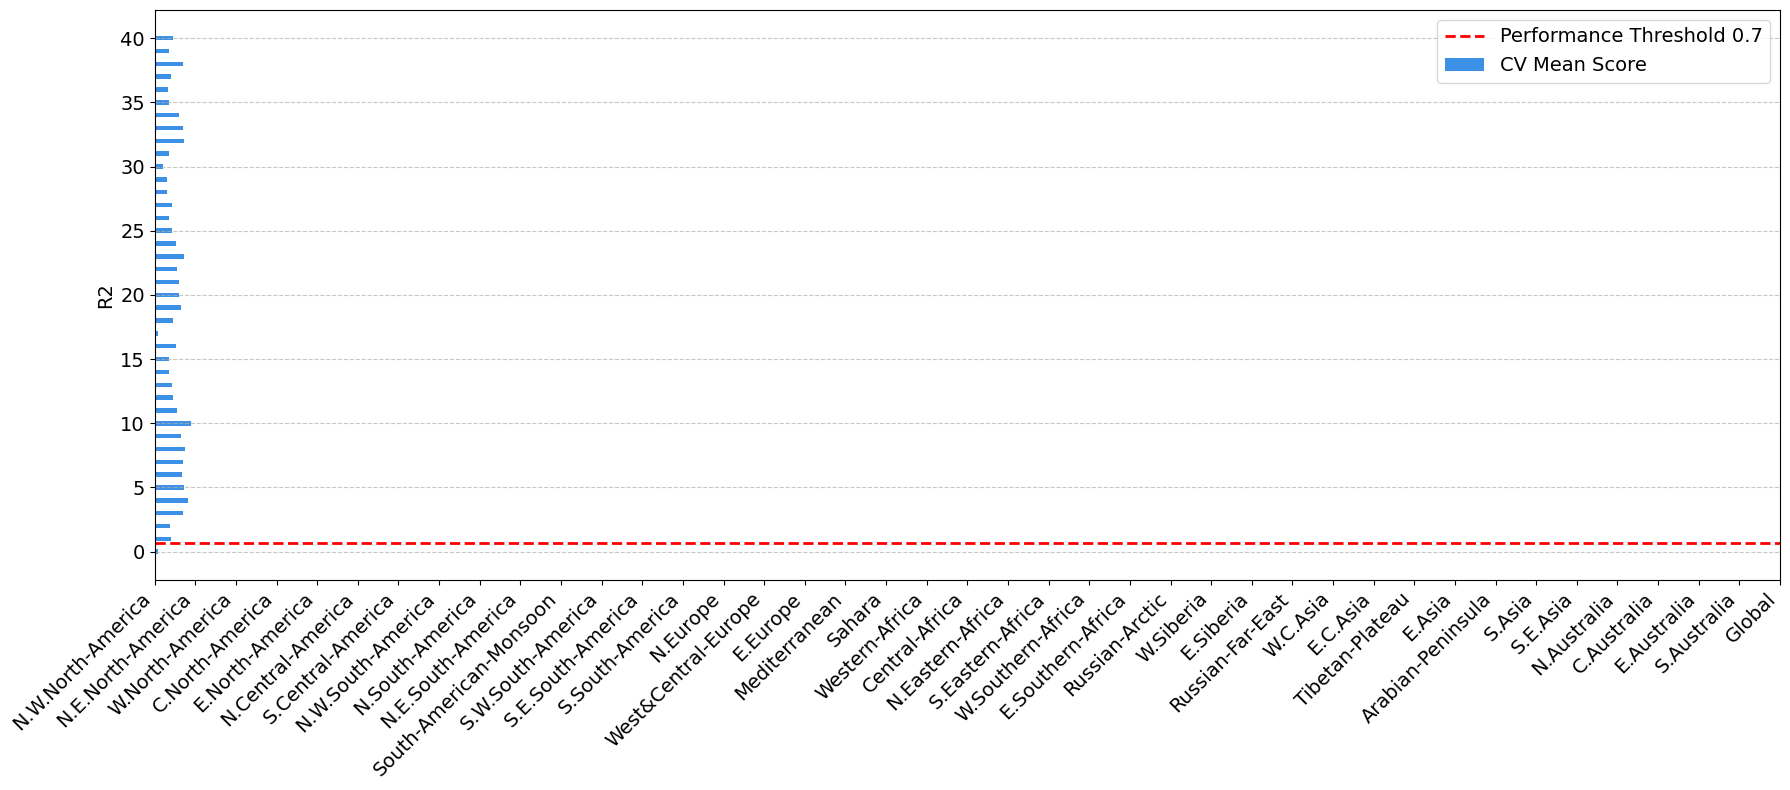

In [66]:
plot_performance_scores_regions(results_regression_analysis_regions, scoring, save_path=None)

#### Subregional Regression Analysis

In [51]:
# Define predictors and predictant
predictor_vars = ['pr', 'vpd', 'mrso', 'lai', 'wue', 'RX5day', 'gsl']  
predictant = 'bgws'
scaling_method = 'max' # None max
test_size = 0.2 # Share of the dataset used as test dataset (default is 0.3)
regression_type='elasticnet' # Regression technique (tested are ridge, lasso and elasticnet)
param_grid=None # Specify parameter grid here if different one to default should be used
grid_cell_threshold=50 # Define threshold for minimum grid cells per region
cv_folds=5 # define k for cross-validation (default is 5)
scoring='r2' # Scoring metric for Cross-Validation, default is r2.
evaluation_method='cv' # Method of evaluation ('test' or 'cv'), default is 'test'.
variable_importance_method='PI' # Method to assess variable importance
n_permutations = 20 #  Number of permutations for permutation importance, default is 20.
selected_region =  None # Specific region to analyze, default is None (analyze all). Define like this [0, 1, 2]
selected_subdivision = None # Specific subdivision to analyze, default is None (analyze all). 'Positive Historical BGWS' or 'Negative Historical BGWS'



# Analyze a specific region and subdivision
results_regression_analysis_regions_subdivisions = reg_analysis.regression_analysis_regions_subdivisions(ds_dict_change_region_sub['Ensemble mean'], 
                                                             predictor_vars, predictant, scaling_method, 
                                                             test_size, regression_type, 
                                                             param_grid, grid_cell_threshold, 
                                                             cv_folds, scoring, evaluation_method, 
                                                             variable_importance_method, n_permutations,
                                                             selected_region, selected_subdivision)

Performing regression analysis for N.W.North-America - Positive Historical BGWS
Regression analysis based on 699 grid cells
Performing regression analysis for N.W.North-America - Negative Historical BGWS
Regression analysis based on 153 grid cells
Performing regression analysis for N.E.North-America - Positive Historical BGWS
Regression analysis based on 604 grid cells
Performing regression analysis for N.E.North-America - Negative Historical BGWS
Regression analysis based on 86 grid cells
Performing regression analysis for W.North-America - Positive Historical BGWS
Regression analysis based on 172 grid cells
Performing regression analysis for W.North-America - Negative Historical BGWS
Regression analysis based on 129 grid cells
Performing regression analysis for C.North-America - Positive Historical BGWS
No regression analysis as grid cells < threshold 
Performing regression analysis for C.North-America - Negative Historical BGWS
Regression analysis based on 264 grid cells
Performing 

In [30]:
# Get mean r2
reg_analysis.compute_mean_r2_regions_subdivisions(results_regression_analysis_regions_subdivisions)

Mean CV Score: 0.51


(None, None, 0.5142531625604493)

In [46]:
reg_analysis.create_results_dataframe_regions_subdivisions(results_regression_analysis_regions_subdivisions)

Region  alpha  l1_ratio  \
0   Negative Historical BGWS - South-American-Monsoon   0.00       0.8   
1        Positive Historical BGWS - S.E.South-America   0.01       0.2   
2          Negative Historical BGWS - N.South-America   0.00       0.8   
3              Negative Historical BGWS - E.Australia   0.00       0.8   
4          Positive Historical BGWS - S.South-America   0.00       0.2   
5        Negative Historical BGWS - N.E.South-America   0.00       0.8   
6   Positive Historical BGWS - South-American-Monsoon   0.01       0.8   
7          Positive Historical BGWS - E.North-America   0.00       0.8   
8        Negative Historical BGWS - N.Central-America   0.01       0.8   
9        Positive Historical BGWS - N.W.South-America   0.00       0.2   
10               Negative Historical BGWS - E.Siberia   0.00       0.8   
11                  Positive Historical BGWS - S.Asia   0.01       0.8   
12          Positive Historical BGWS - Western-Africa   0.00       0.2   
13        Negative Historical BGWS - S.Eastern-Africa   0.01       0.8   
14       Negative Historical BGWS - W.Southern-Africa   0.00       0.5   
15                  Positive Historical BGWS - E.Asia   0.00       0.8   
16          Negative Historical BGWS - Central-Africa   0.00       0.8   
17       Negative Historical BGWS - Arabian-Peninsula   0.01       0.8   
18         Negative Historical BGWS - C.North-America   0.00       0.8   
19                  Negative Historical BGWS - S.Asia   0.01       0.8   
20          Negative Historical BGWS - Western-Africa   0.00       0.2   
21       Negative Historical BGWS - S.Central-America   0.01       0.2   
22       Positive Historical BGWS - N.E.South-America   0.01       0.5   
23         Positive Historical BGWS - W.North-America   0.01       0.5   
24         Negative Historical BGWS - E.North-America   0.00       0.2   
25       Positive Historical BGWS - Arabian-Peninsula   0.10       0.8   
26               Positive Historical BGWS - W.Siberia   0.00       0.2   
27       Negative Historical BGWS - N.E.North-America   0.01       0.8   
28                  Negative Historical BGWS - Global   0.00       0.8   
29     Positive Historical BGWS - West&Central-Europe   0.01       0.8   
30        Negative Historical BGWS - N.Eastern-Africa   0.01       0.8   
31             Negative Historical BGWS - N.Australia   0.00       0.2   
32                  Negative Historical BGWS - E.Asia   0.00       0.8   
33               Positive Historical BGWS - E.Siberia   0.00       0.5   
34                  Negative Historical BGWS - Sahara   0.00       0.2   
35                Positive Historical BGWS - E.Europe   0.00       0.8   
36       Positive Historical BGWS - S.W.South-America   0.00       0.2   
37       Positive Historical BGWS - N.E.North-America   0.00       0.5   
38             Negative Historical BGWS - C.Australia   0.00       0.2   
39                Negative Historical BGWS - W.C.Asia   0.00       0.2   
40       Negative Historical BGWS - E.Southern-Africa   0.01       0.8   
41                Positive Historical BGWS - N.Europe   0.00       0.2   
42                  Positive Historical BGWS - Global   0.00       0.8   
43         Negative Historical BGWS - W.North-America   0.00       0.8   
44                Negative Historical BGWS - E.Europe   0.00       0.8   
45          Positive Historical BGWS - Russian-Arctic   0.00       0.8   
46               Negative Historical BGWS - W.Siberia   0.00       0.8   
47                  Positive Historical BGWS - Sahara   0.00       0.5   
48        Positive Historical BGWS - Russian-Far-East   0.00       0.2   
49                Positive Historical BGWS - S.E.Asia   0.00       0.8   
50     Negative Historical BGWS - West&Central-Europe   0.00       0.2   
51                Negative Historical BGWS - E.C.Asia   0.01       0.2   
52             Negative Historical BGWS - S.Australia   0.01       0.8   
53         Positive Historical BGWS - Tibetan-Plate

In [48]:
importlib.reload(reg_plots)

<module 'regression_analysis_plots' from '/work/ch0636/g300115/phd_project/common/src/visualization/regression_analysis_plots.py'>

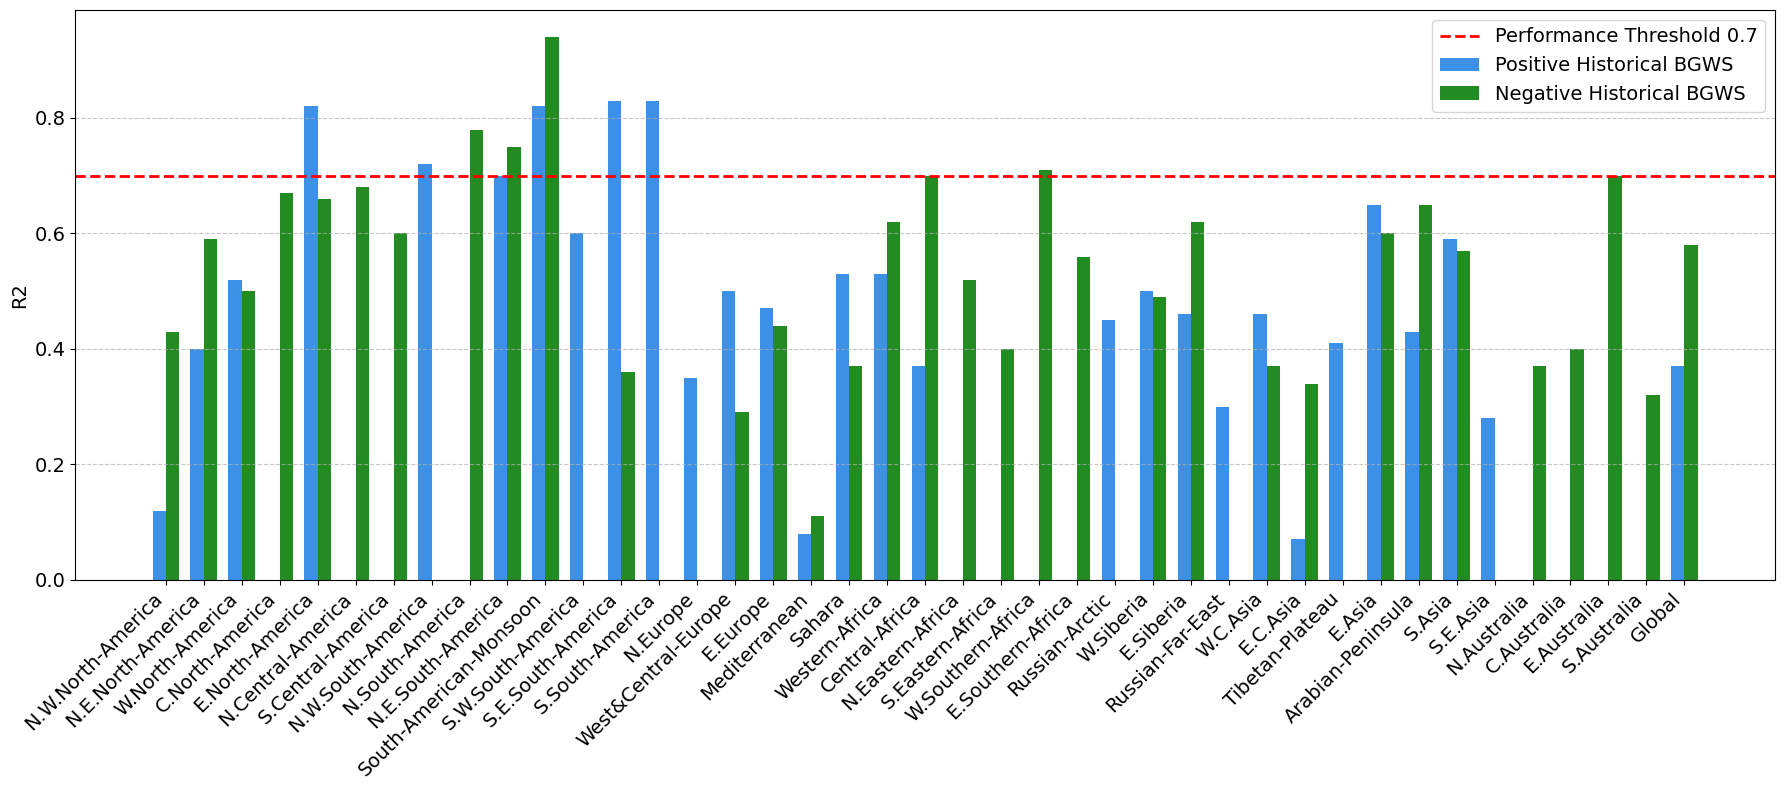

In [52]:
reg_plots.plot_performance_scores_regions_subdivisions(results_regression_analysis_regions_subdivisions, score_type=scoring, 
                                  save_path='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/')

#### Plot Performance Metrics

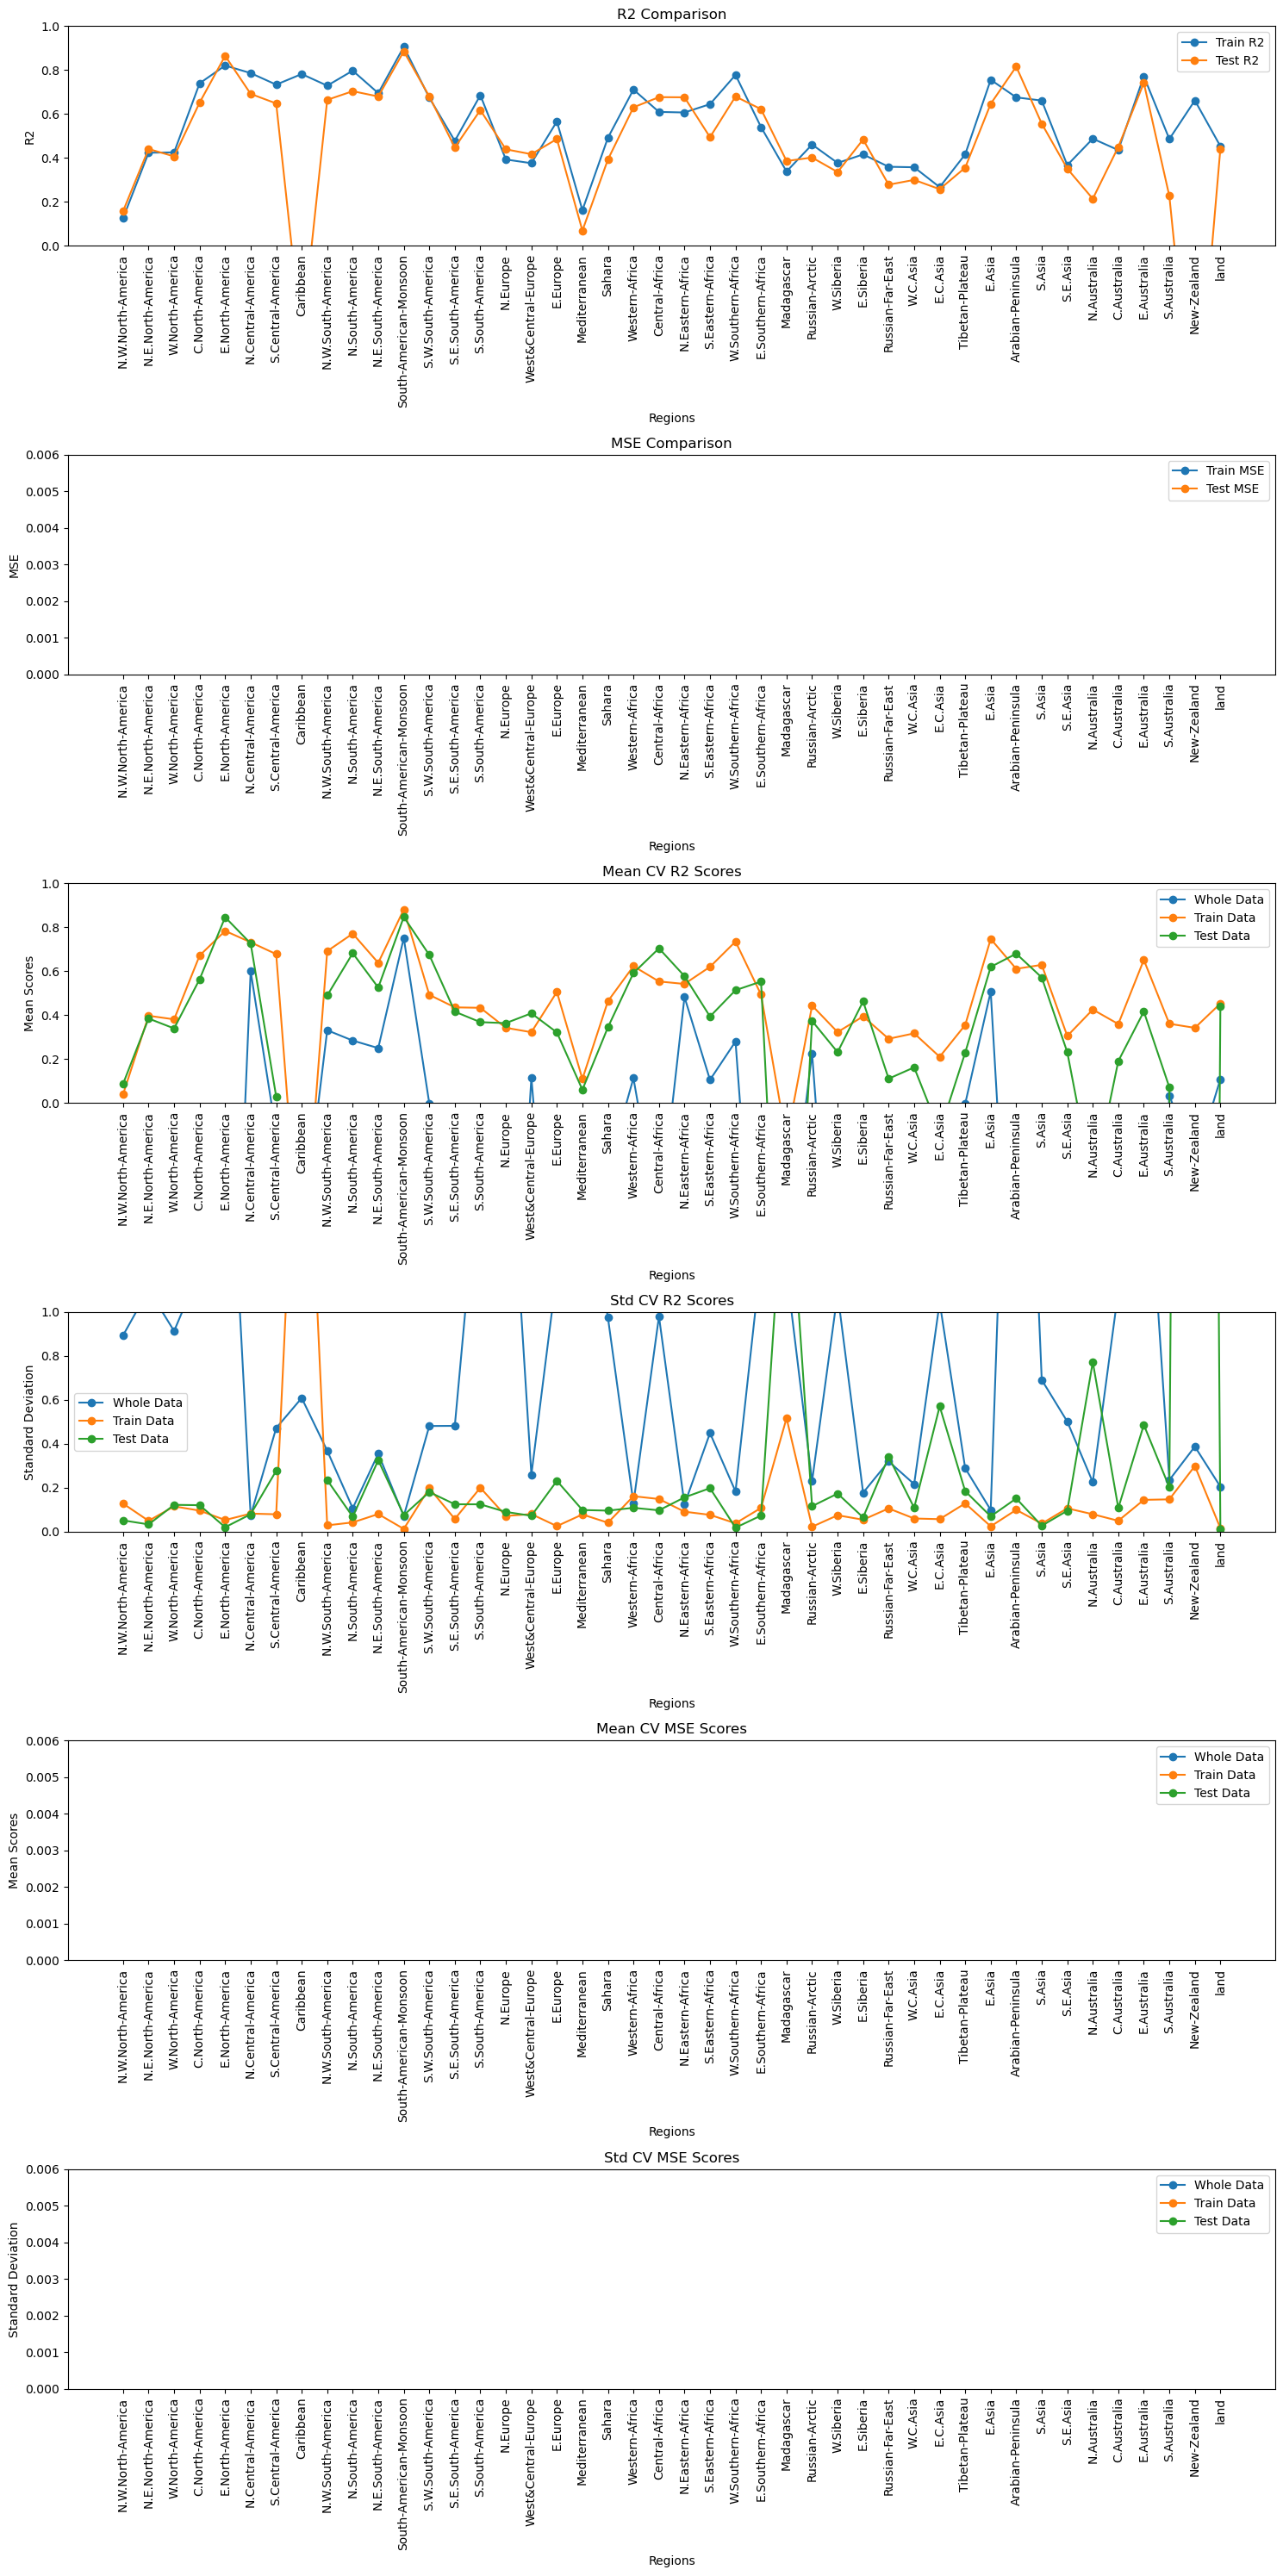

In [43]:
plot_performance_metrics(performance_metrics_train_lr, 
                         performance_metrics_test_lr, 
                         cv_scores_r2_lr, 
                         cv_scores_mse_lr, 
                         cv_scores_r2_train_lr, 
                         cv_scores_mse_train_lr,
                         cv_scores_r2_test_lr, 
                         cv_scores_mse_test_lr)

## 5. Driver Analysis

In [ ]:
# Plot permutation importance

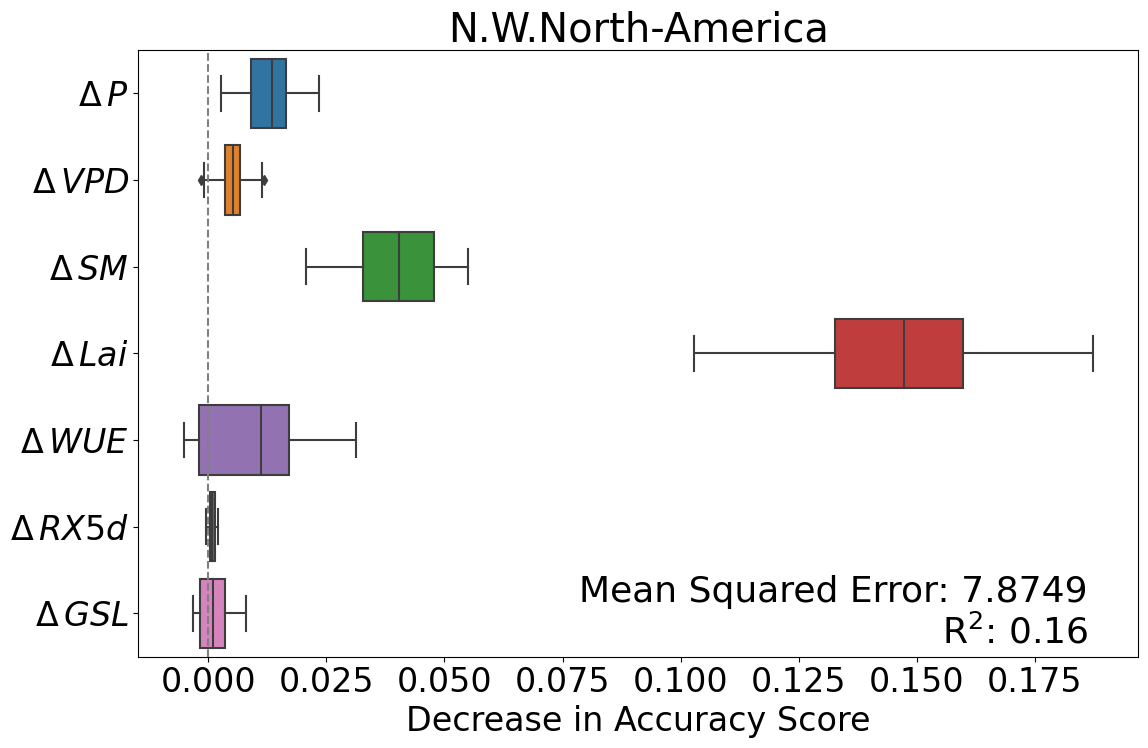

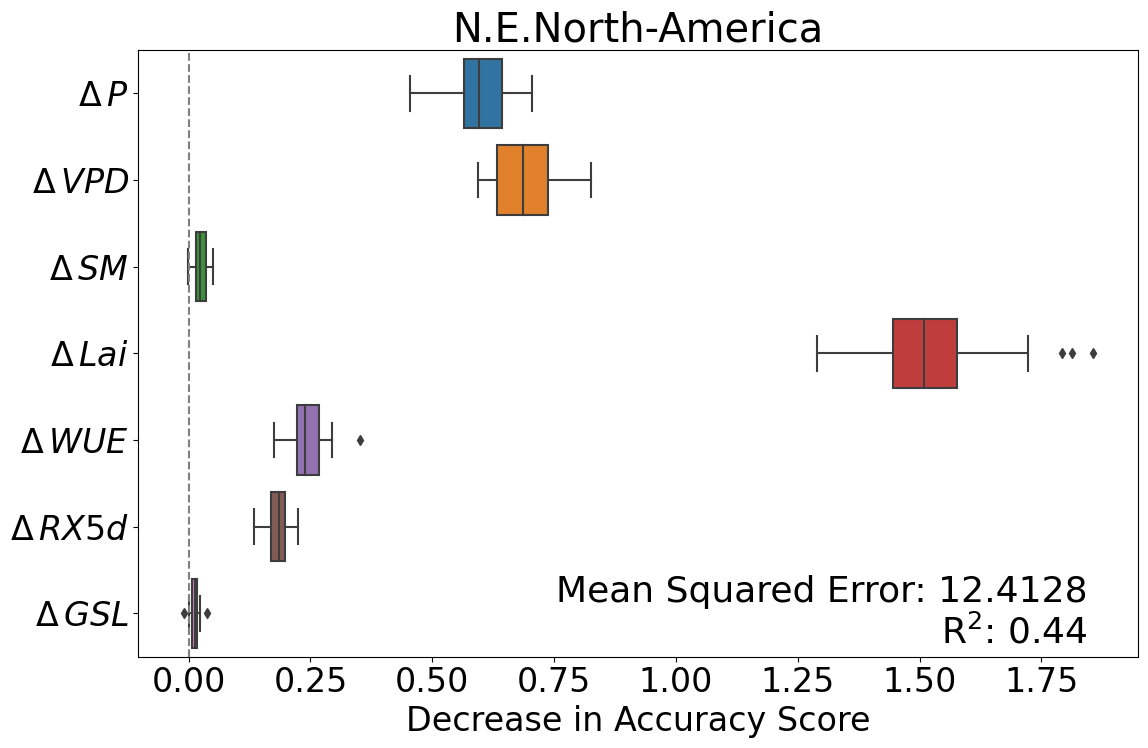

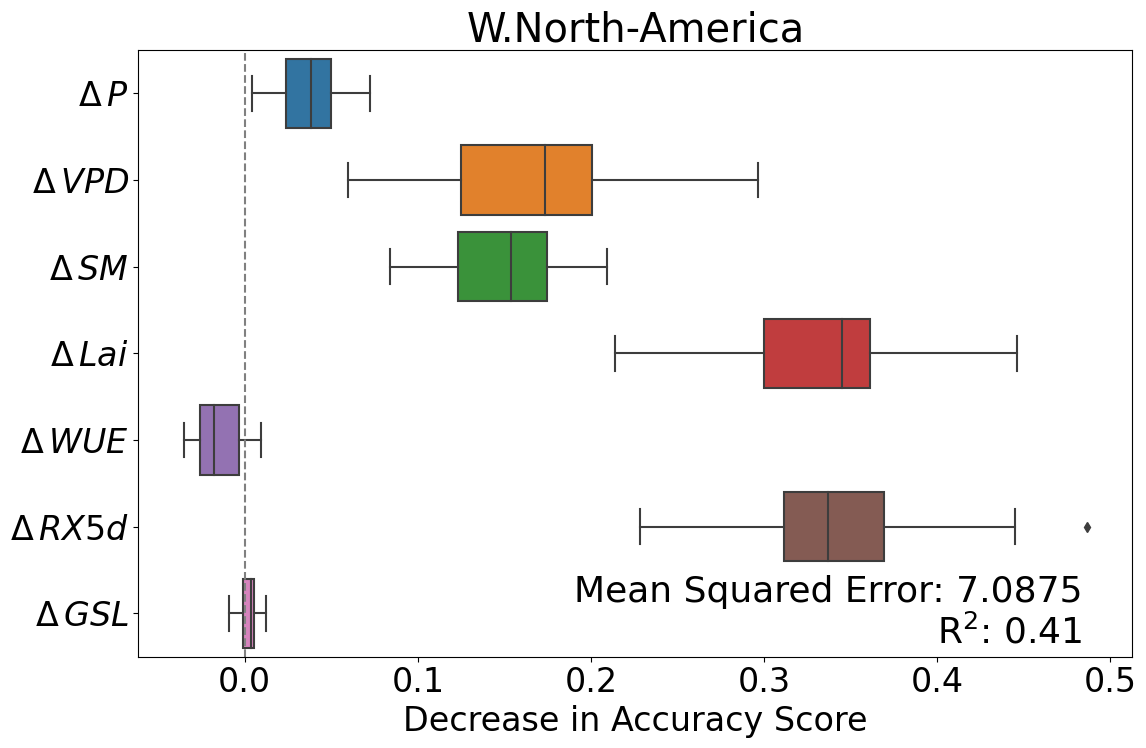

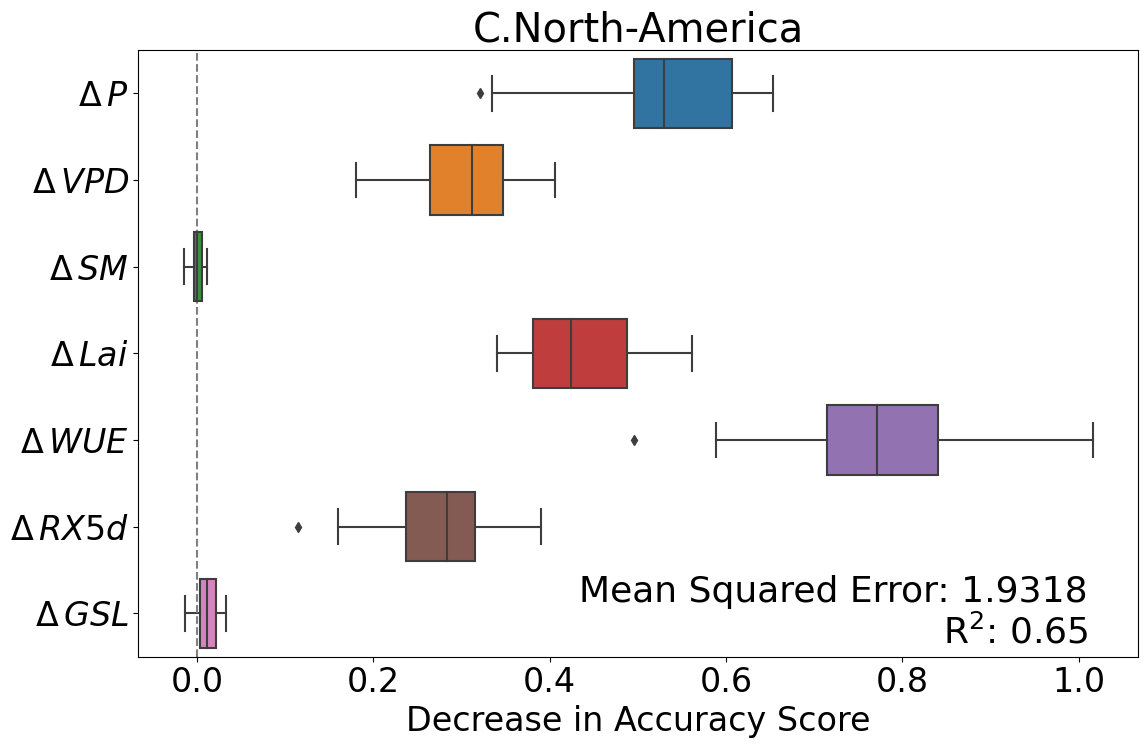

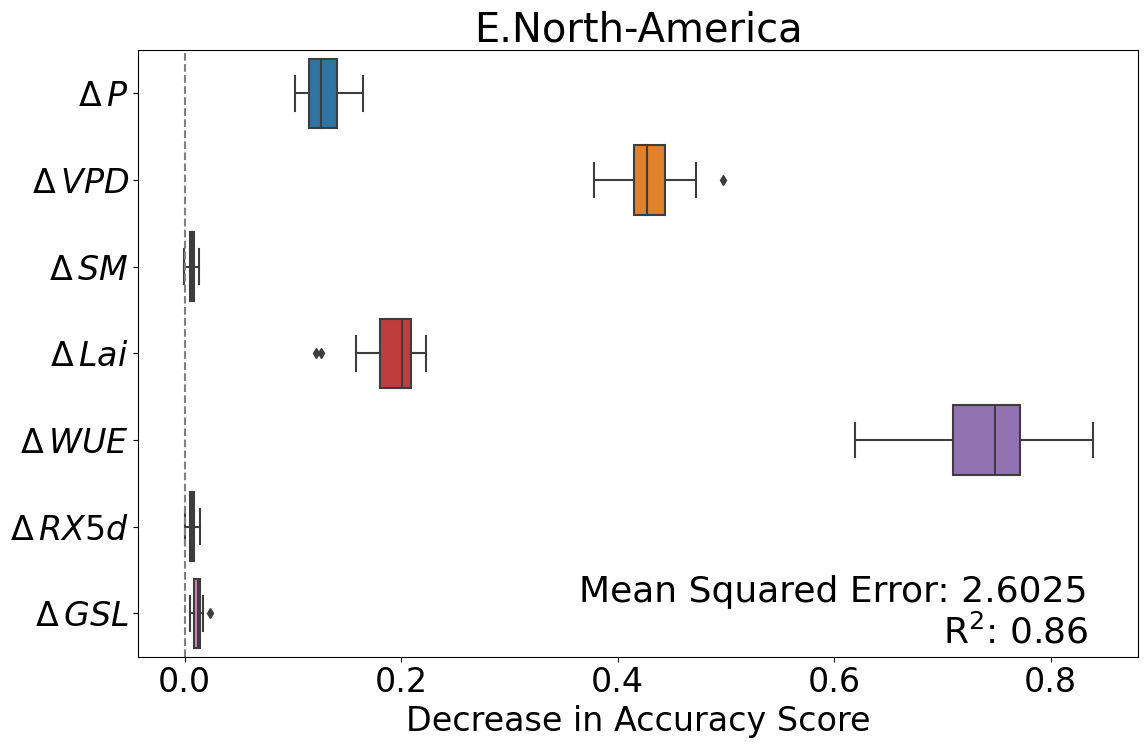

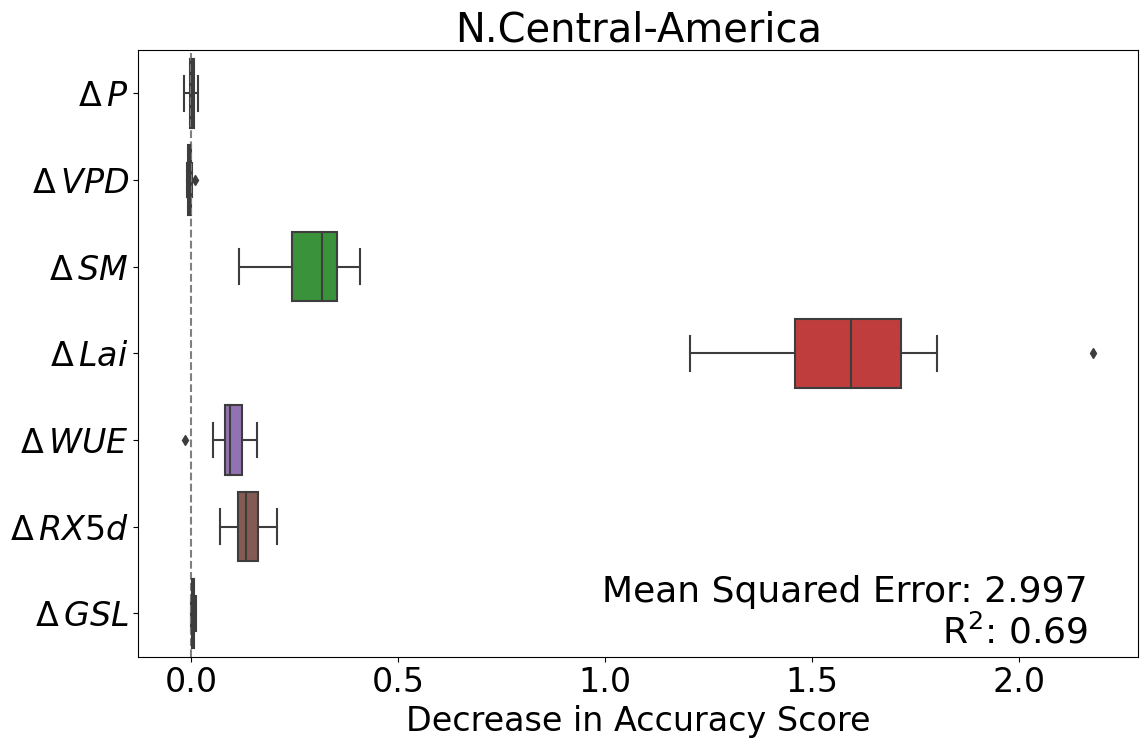

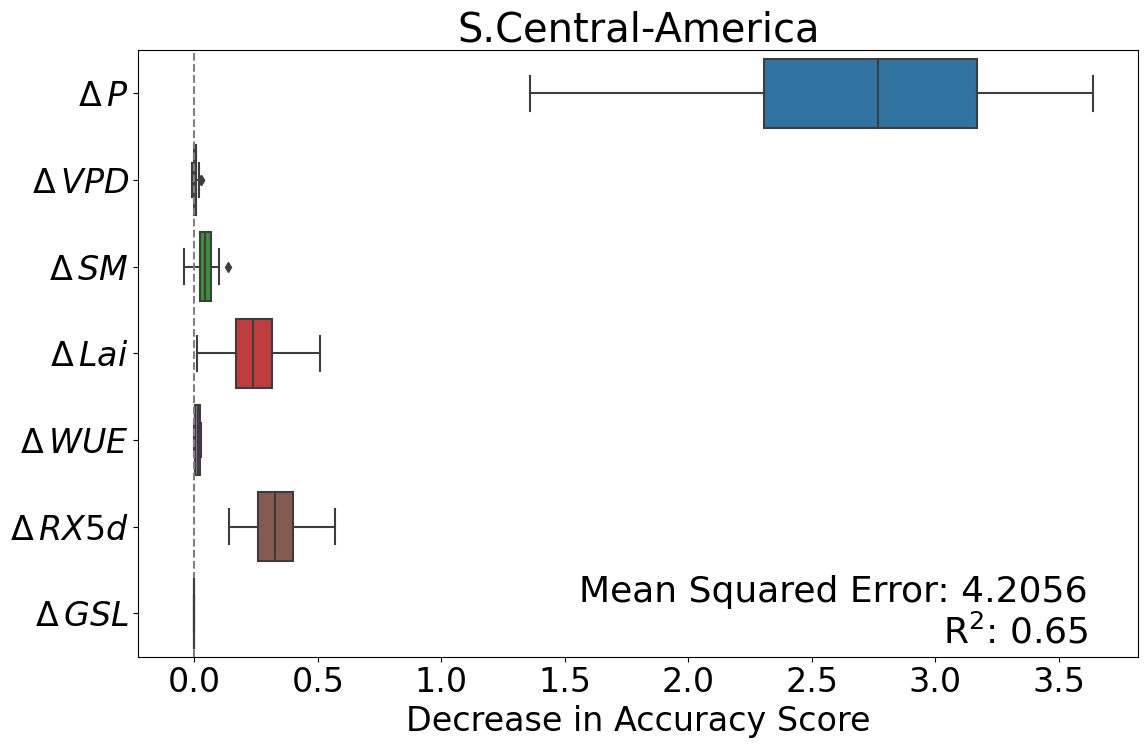

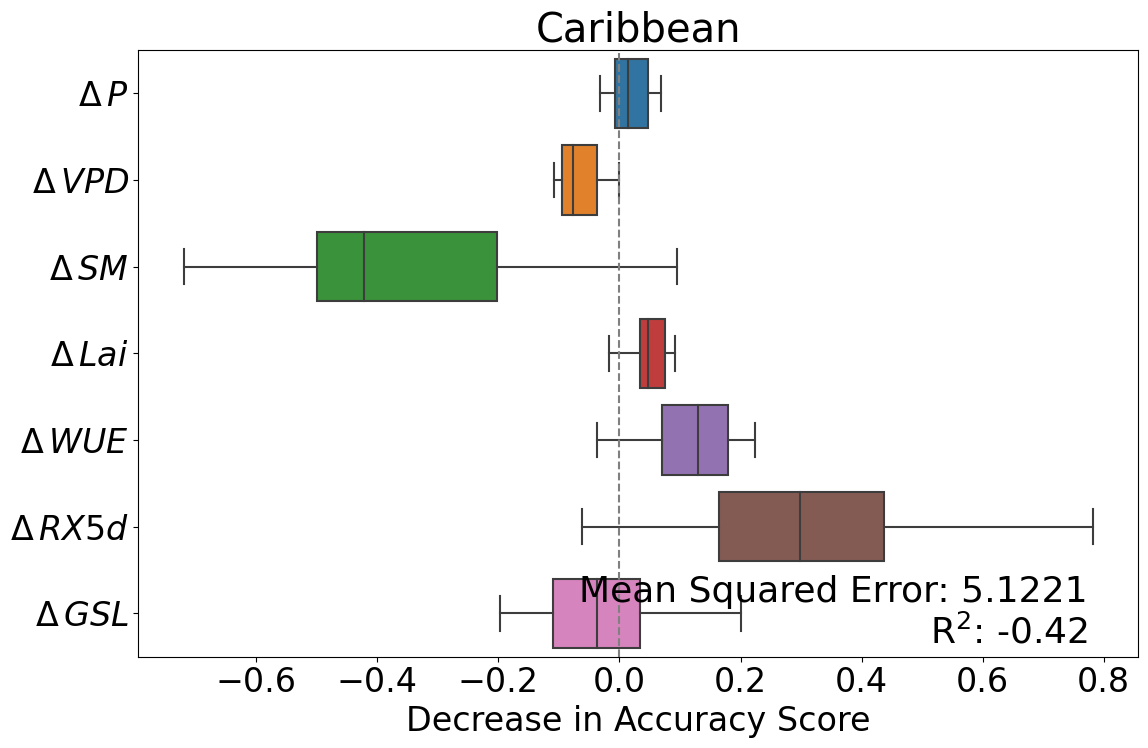

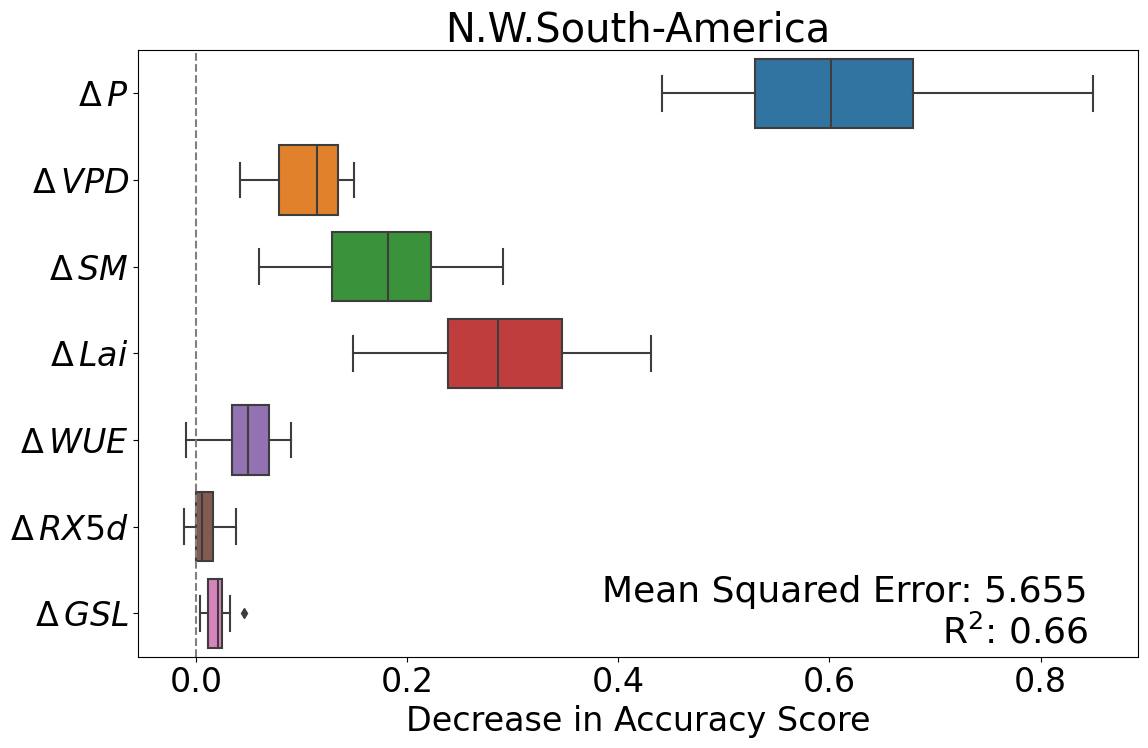

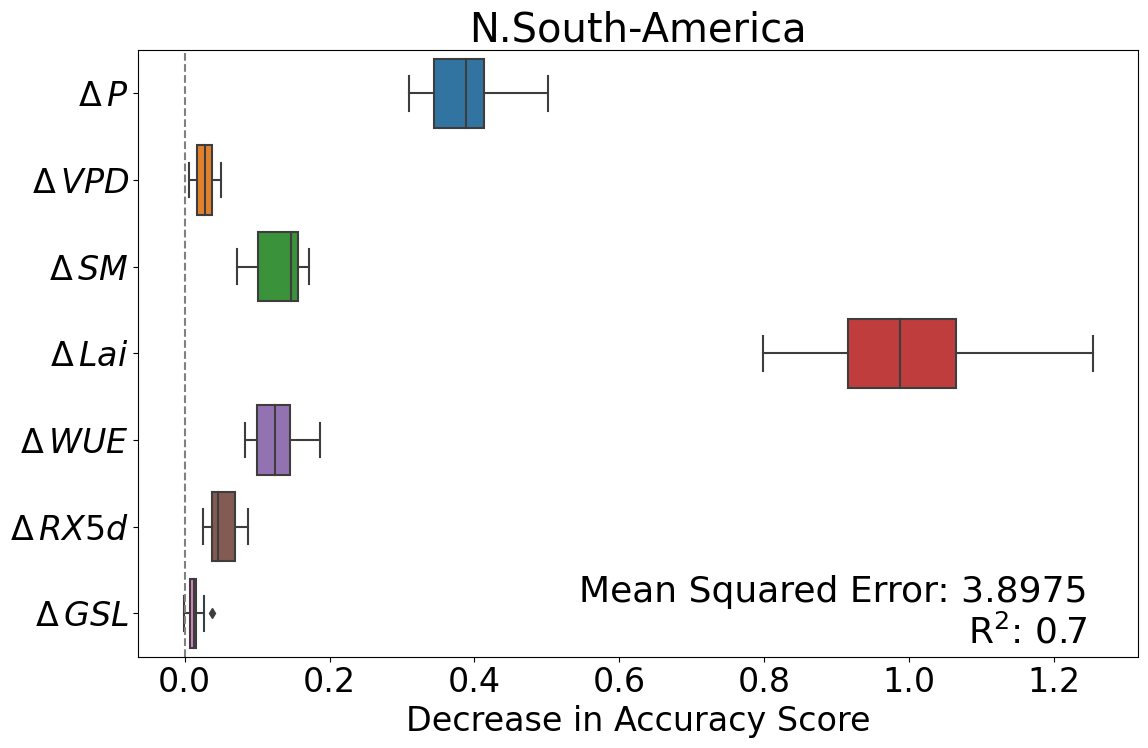

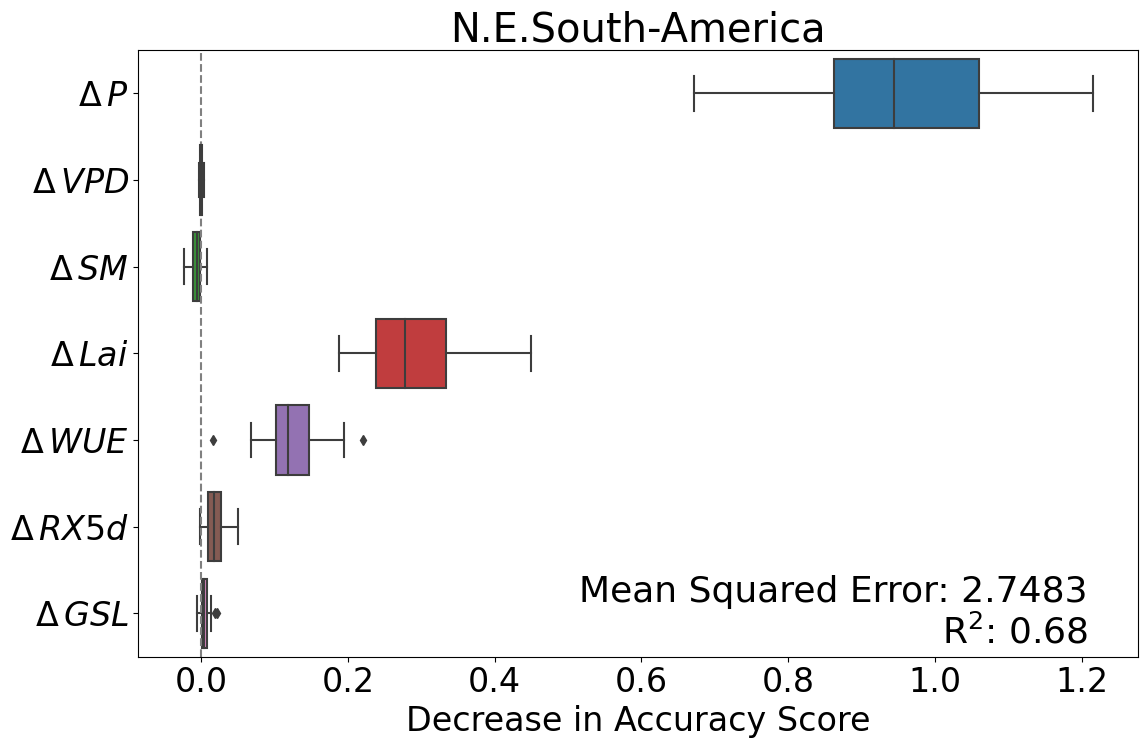

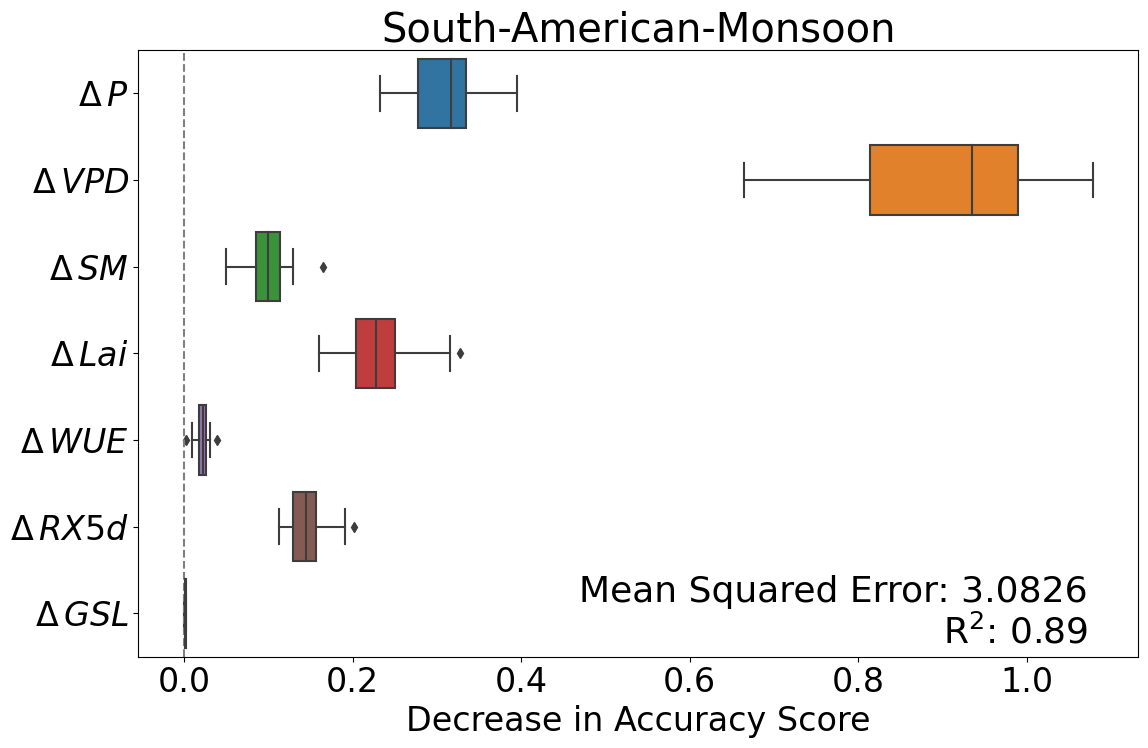

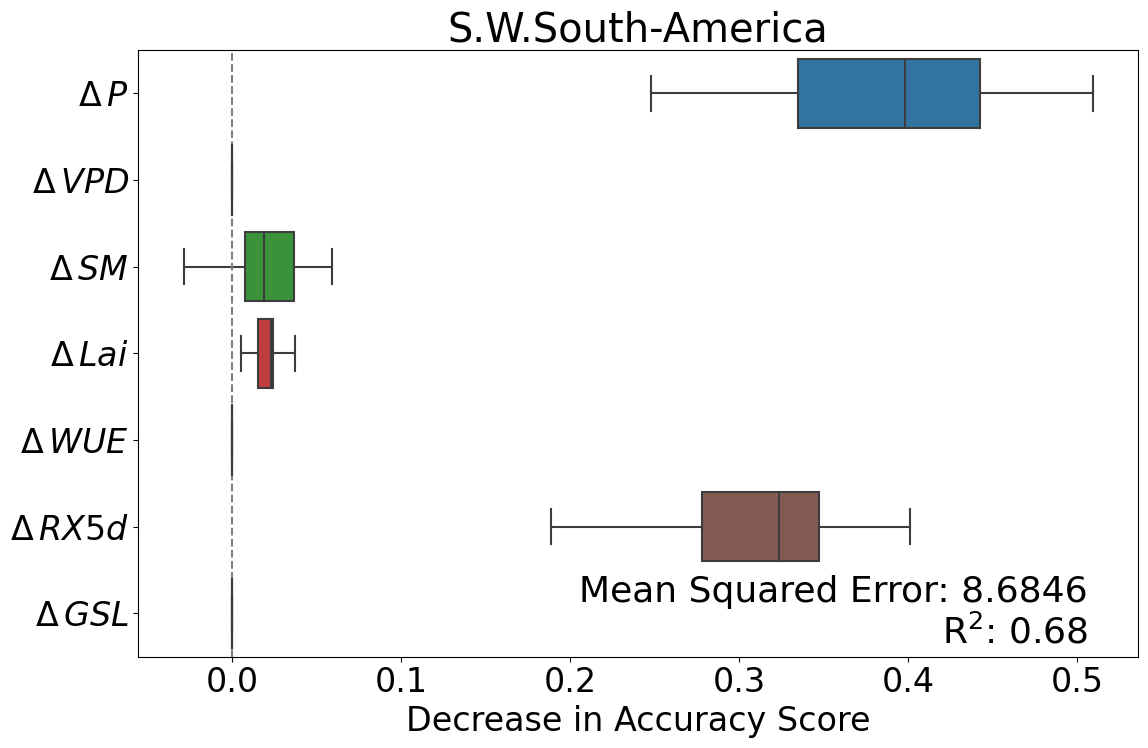

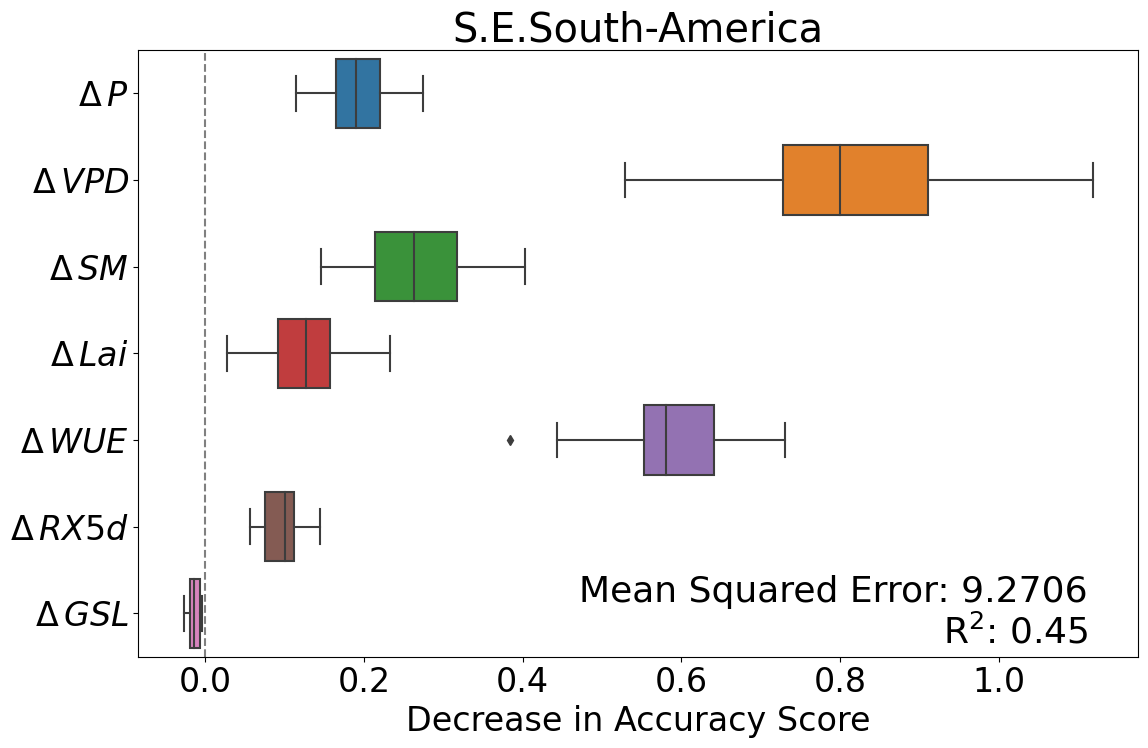

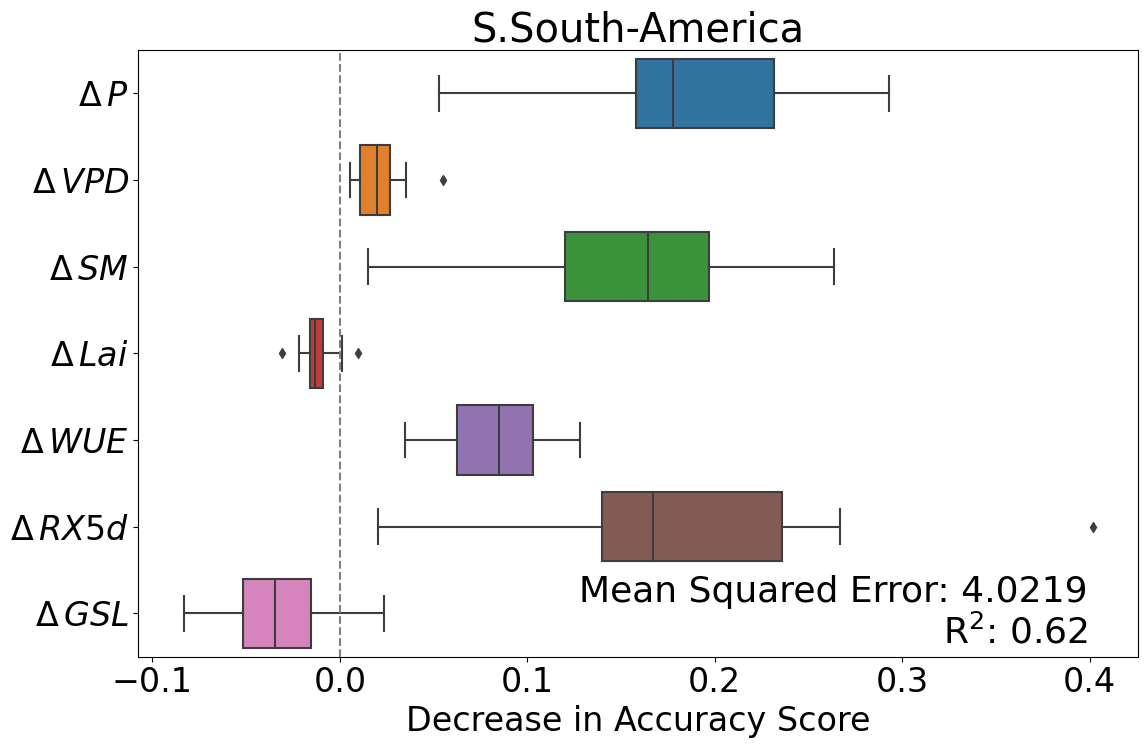

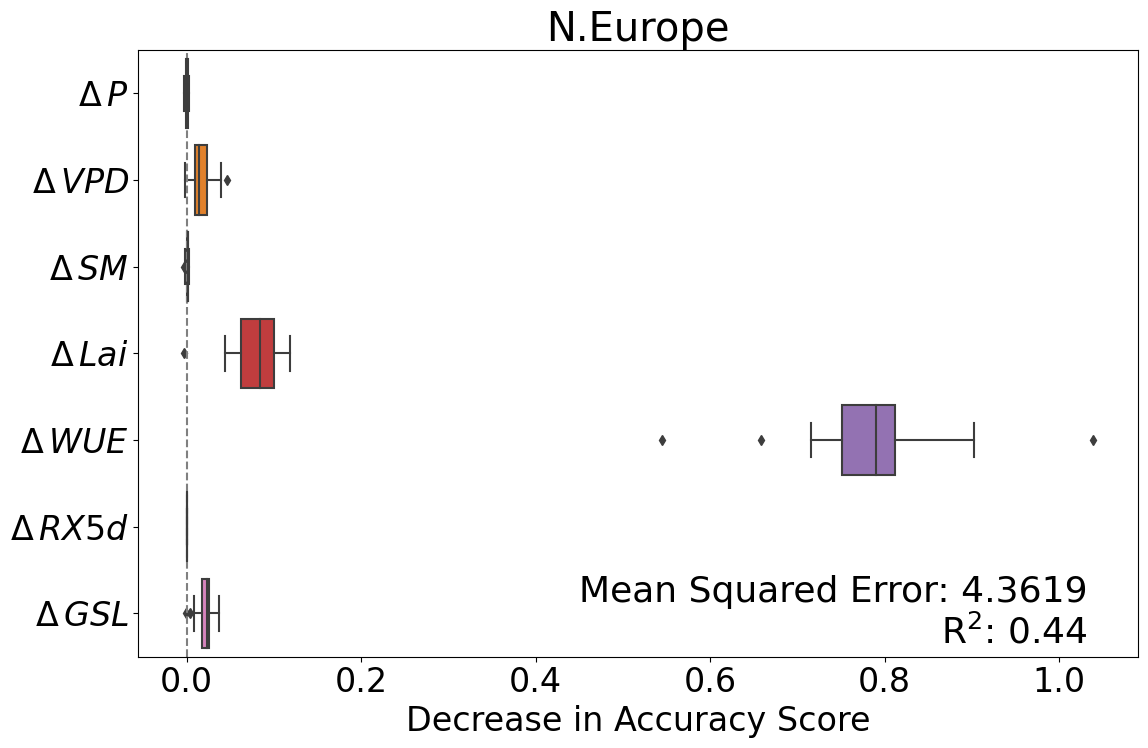

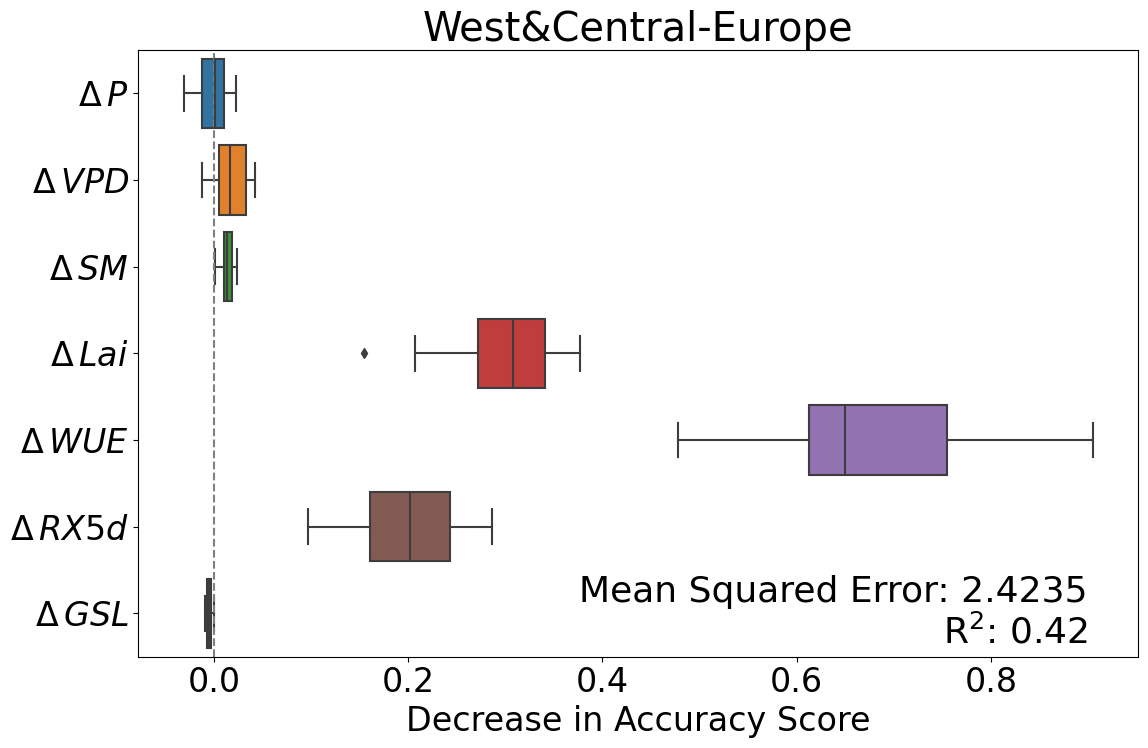

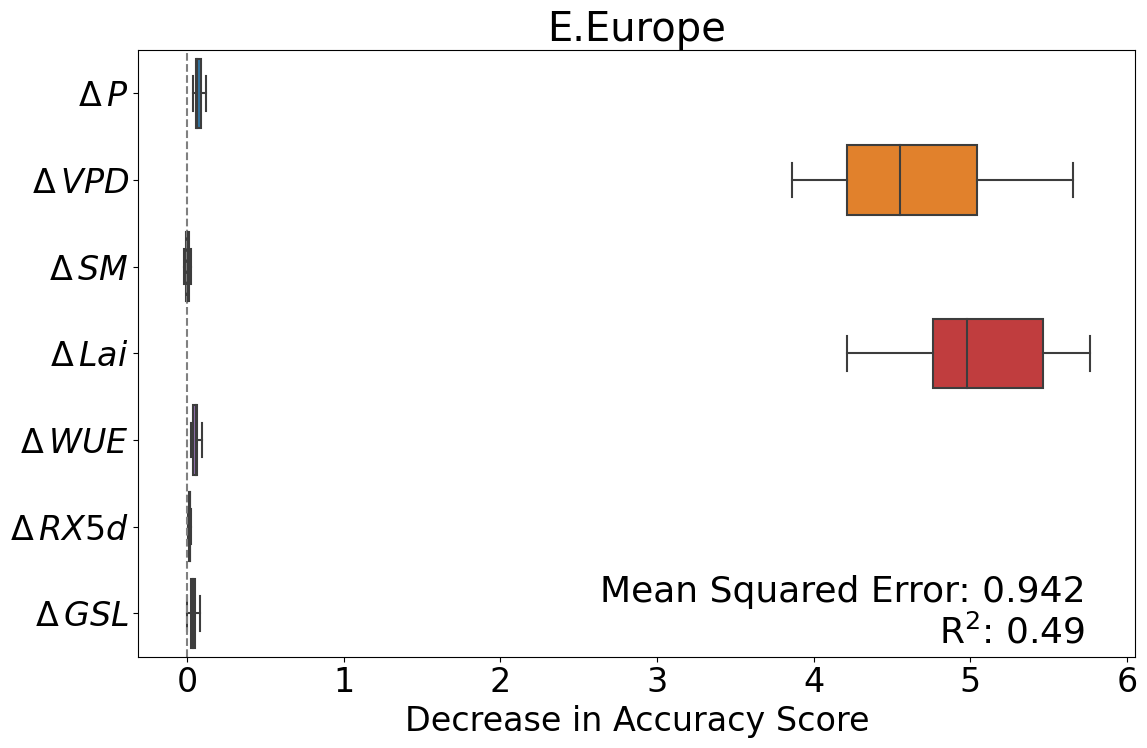

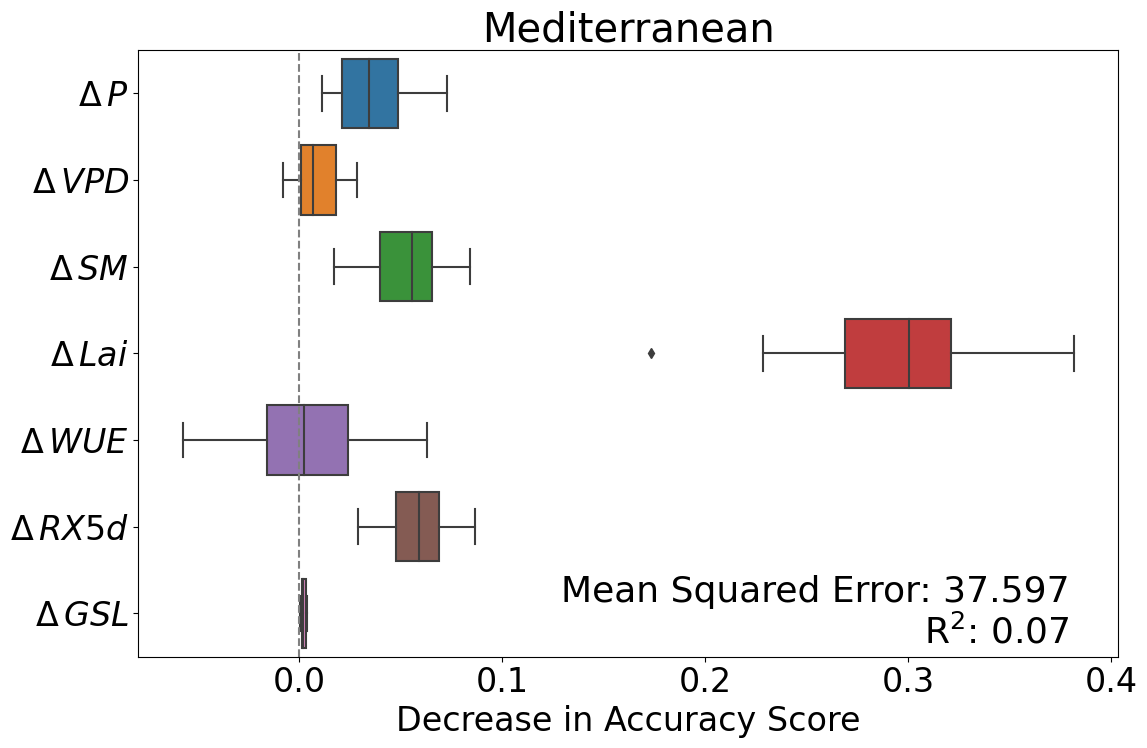

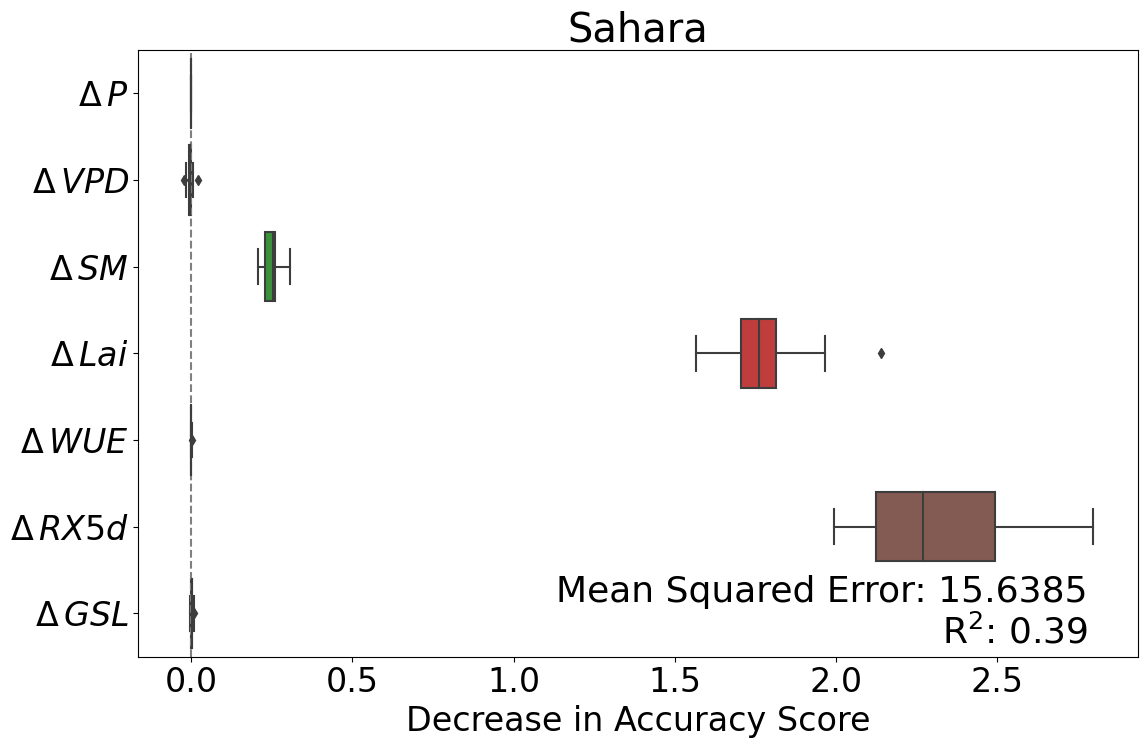

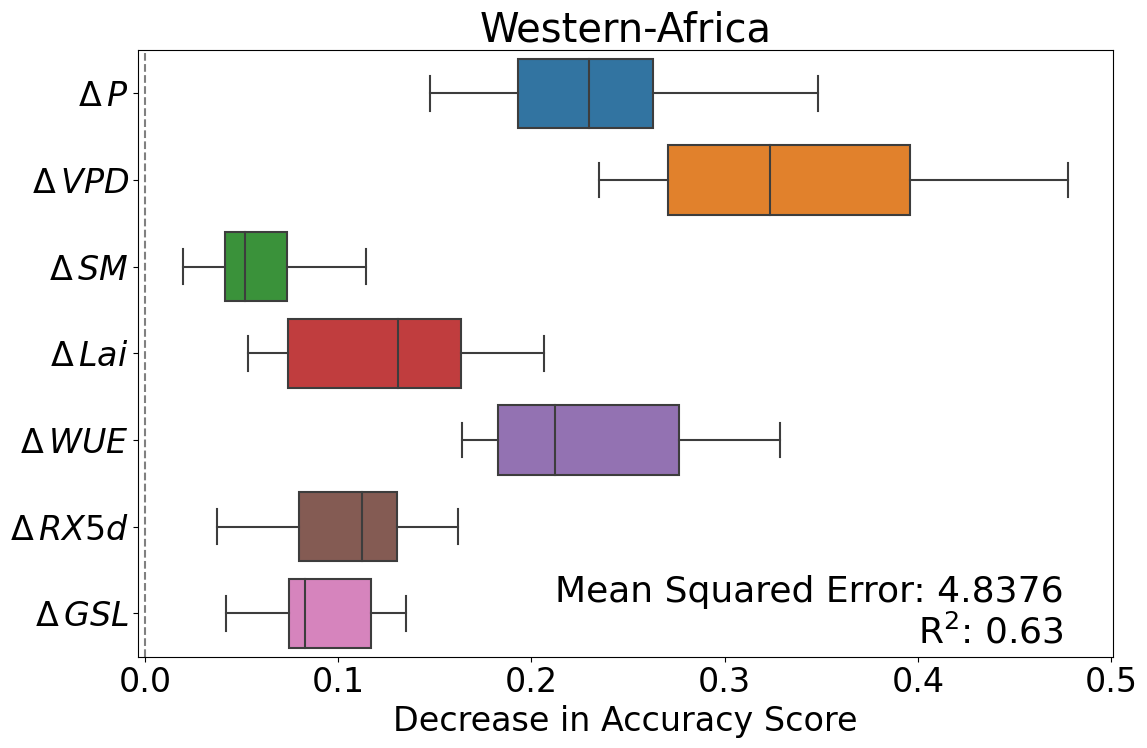

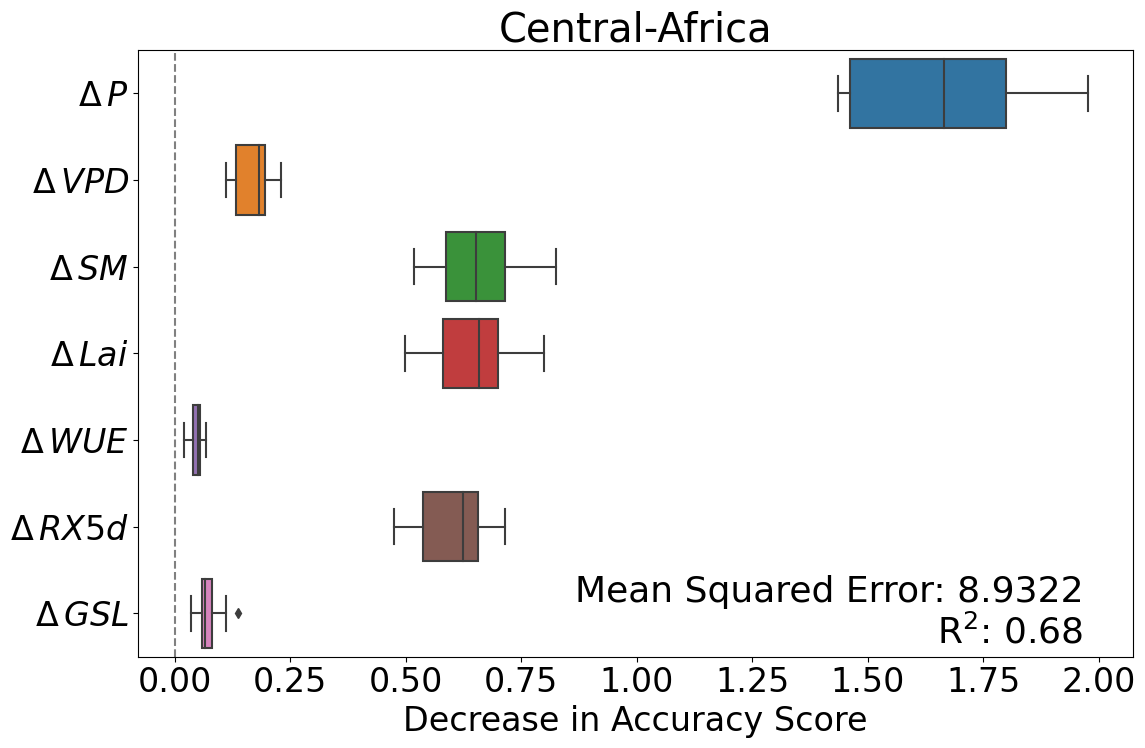

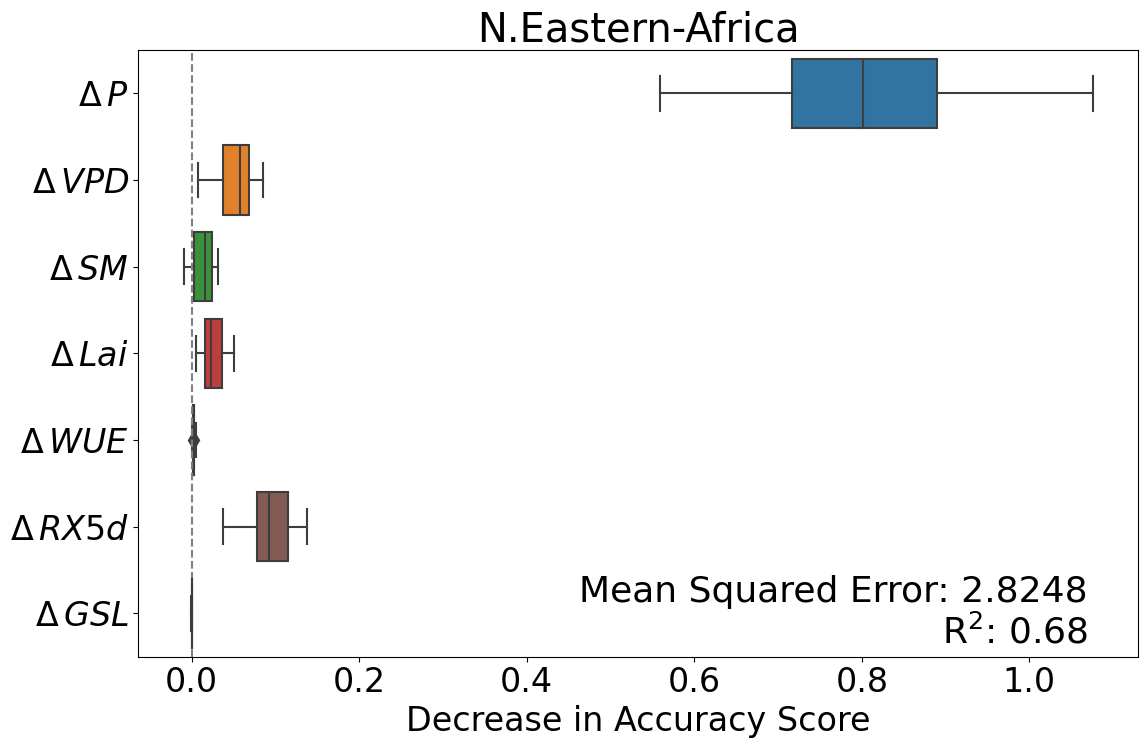

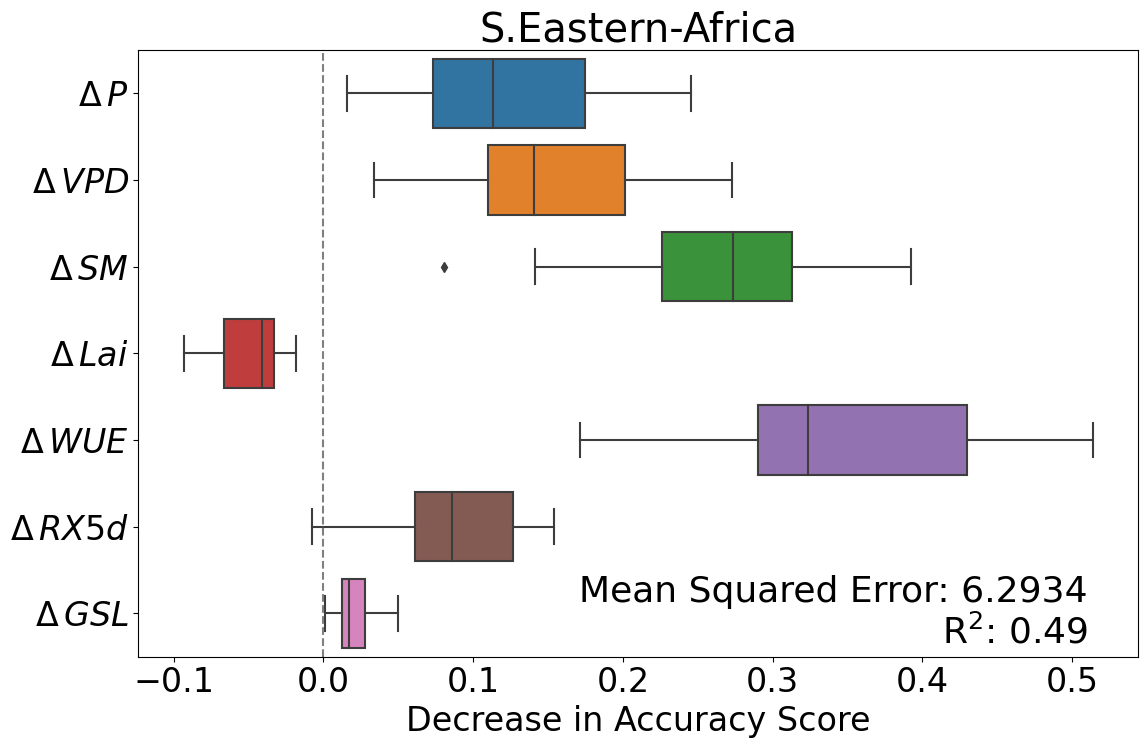

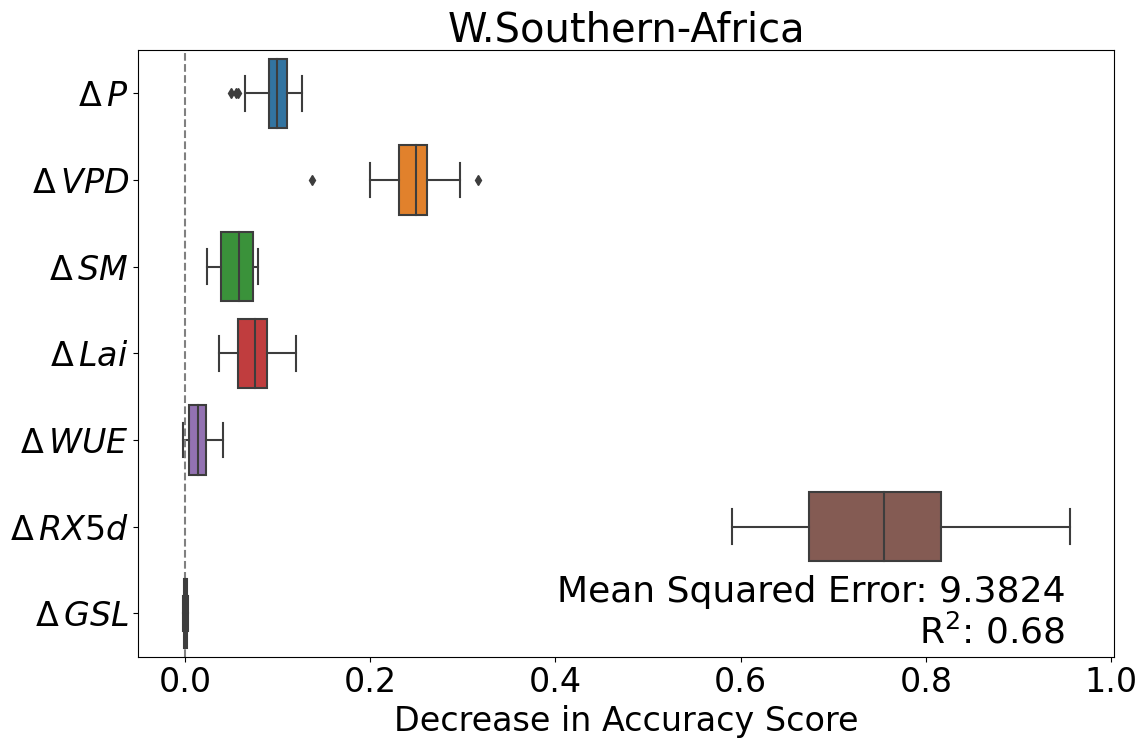

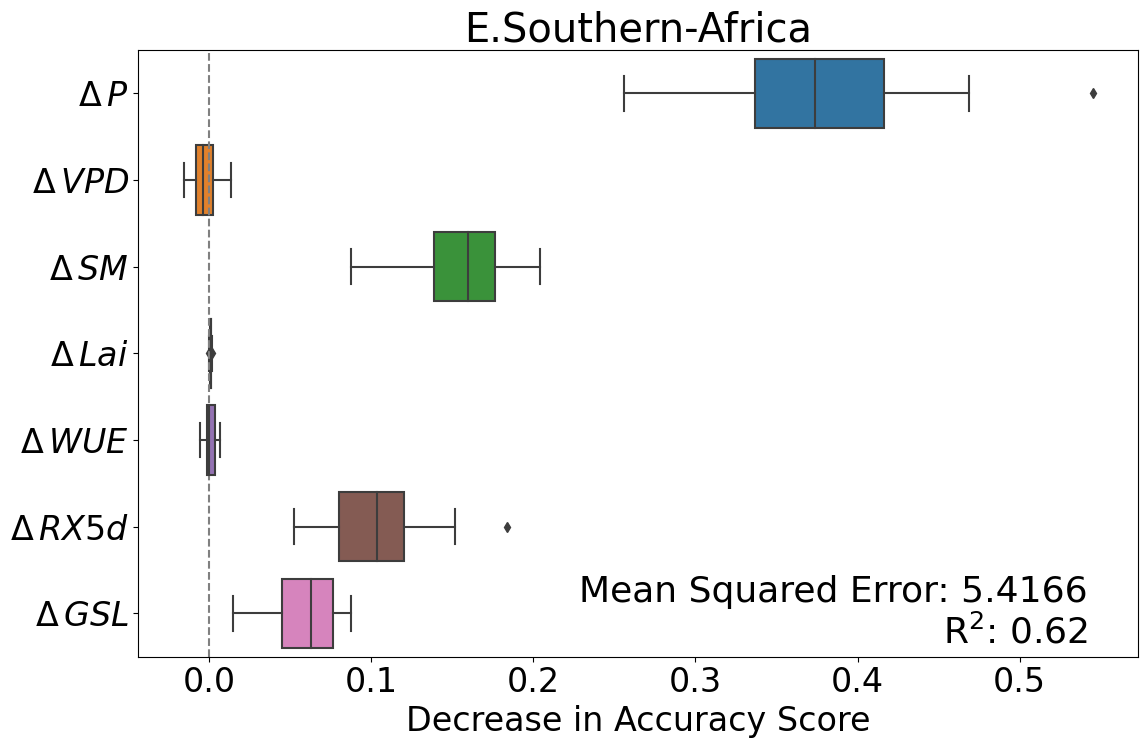

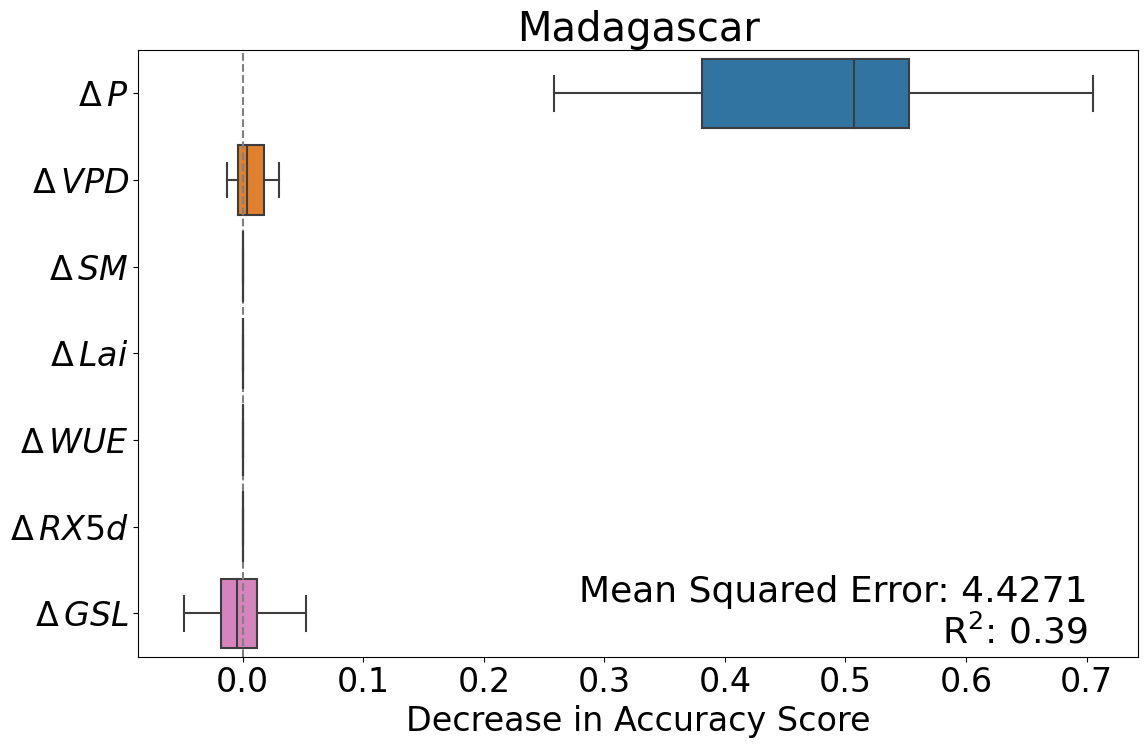

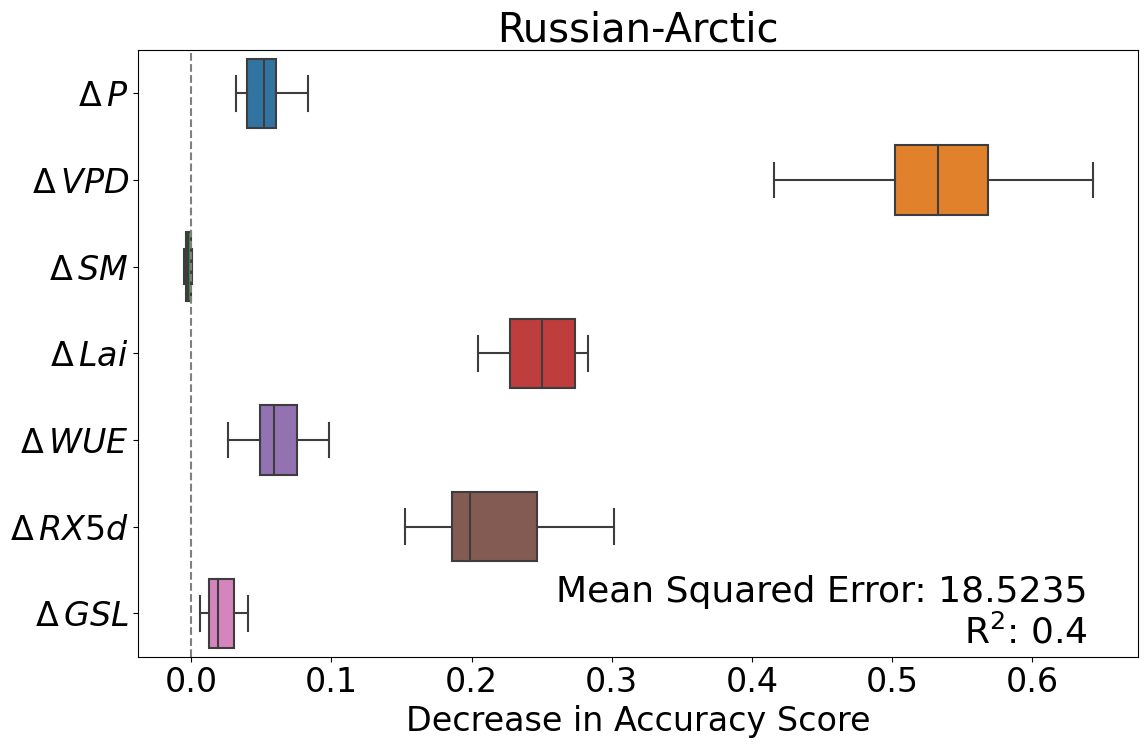

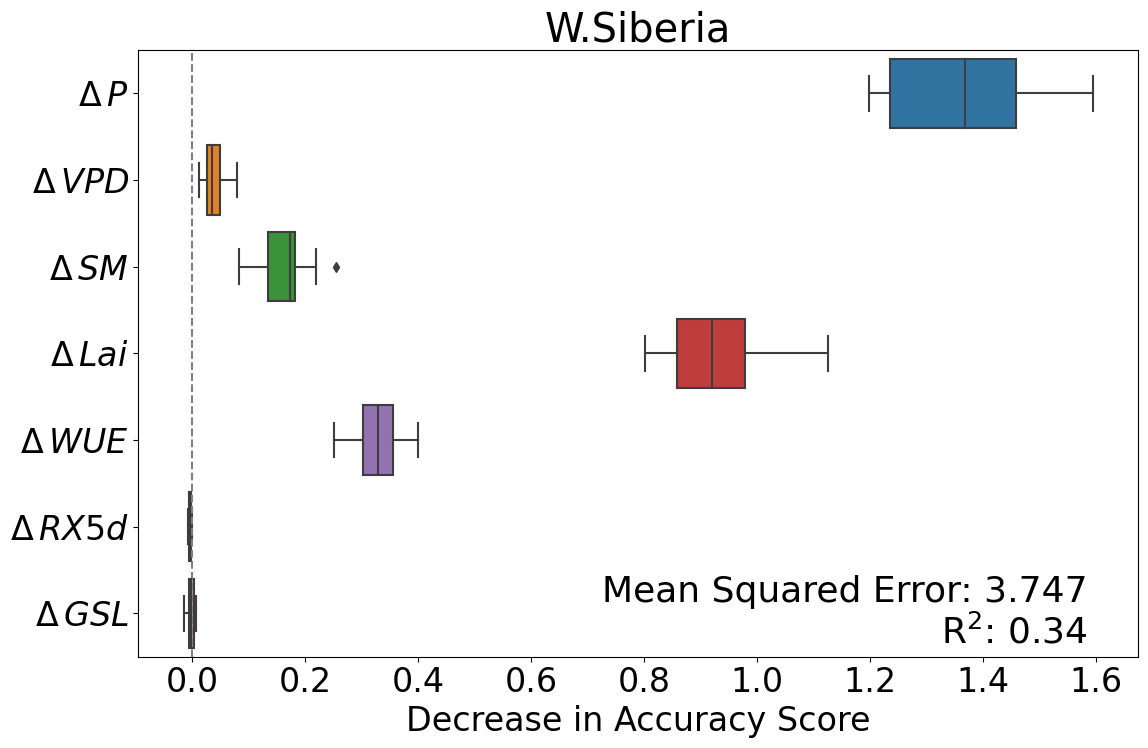

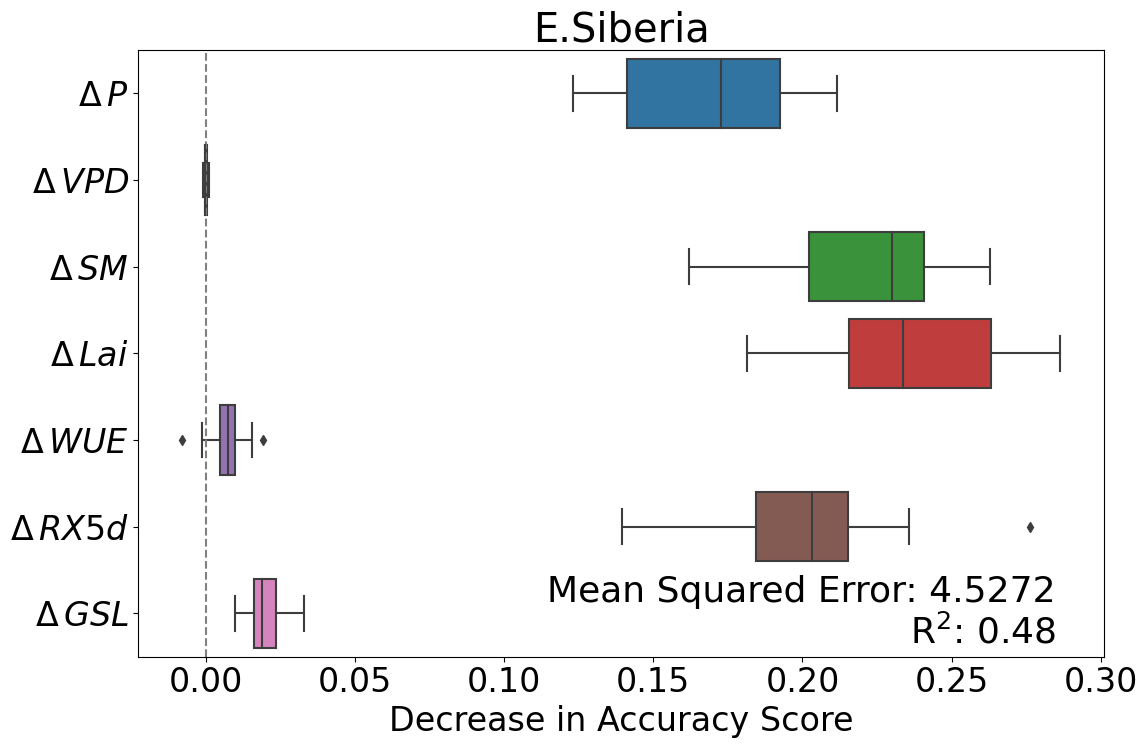

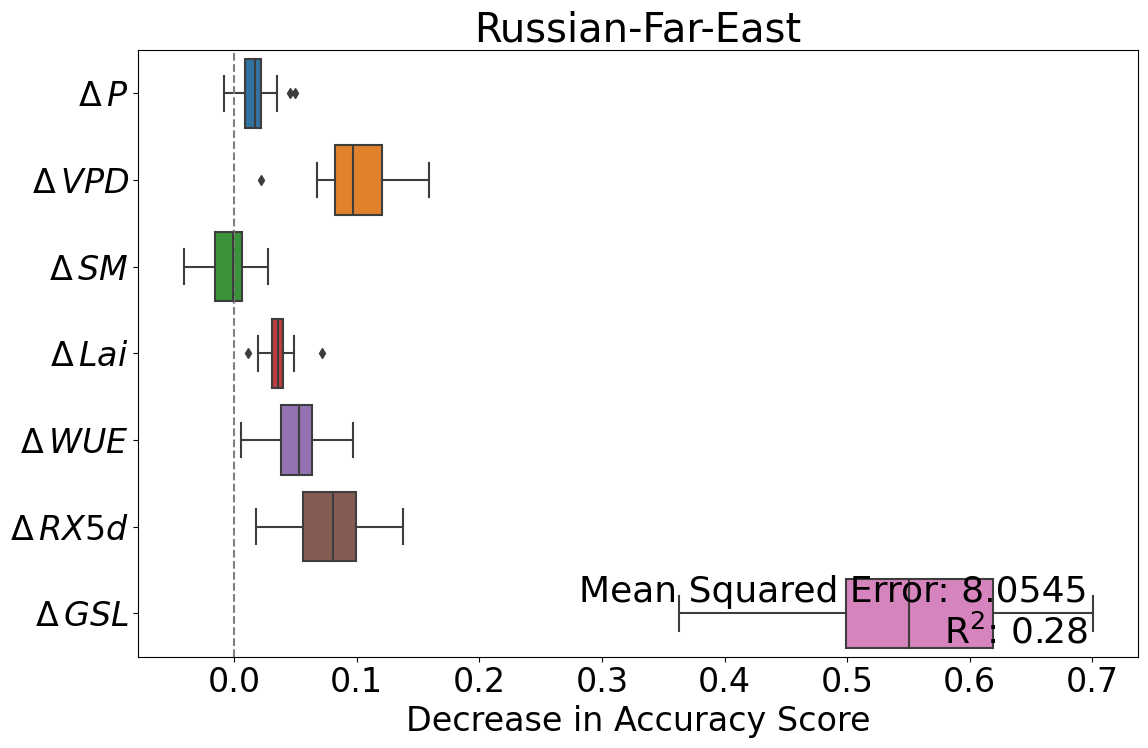

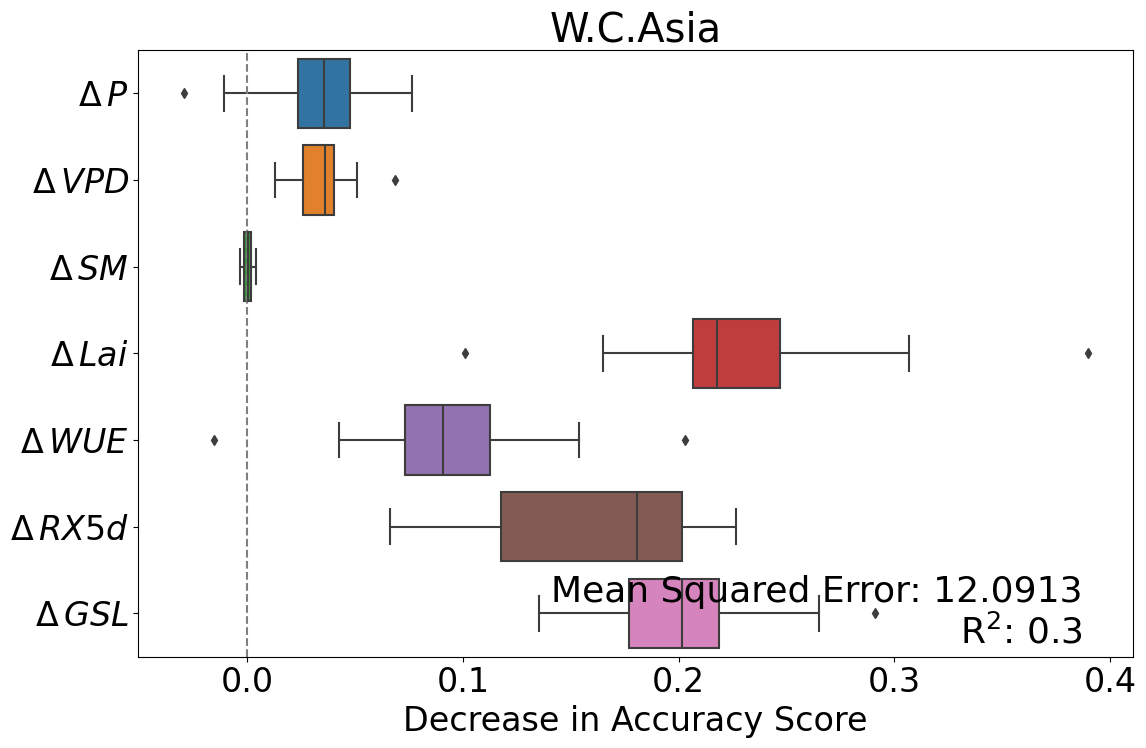

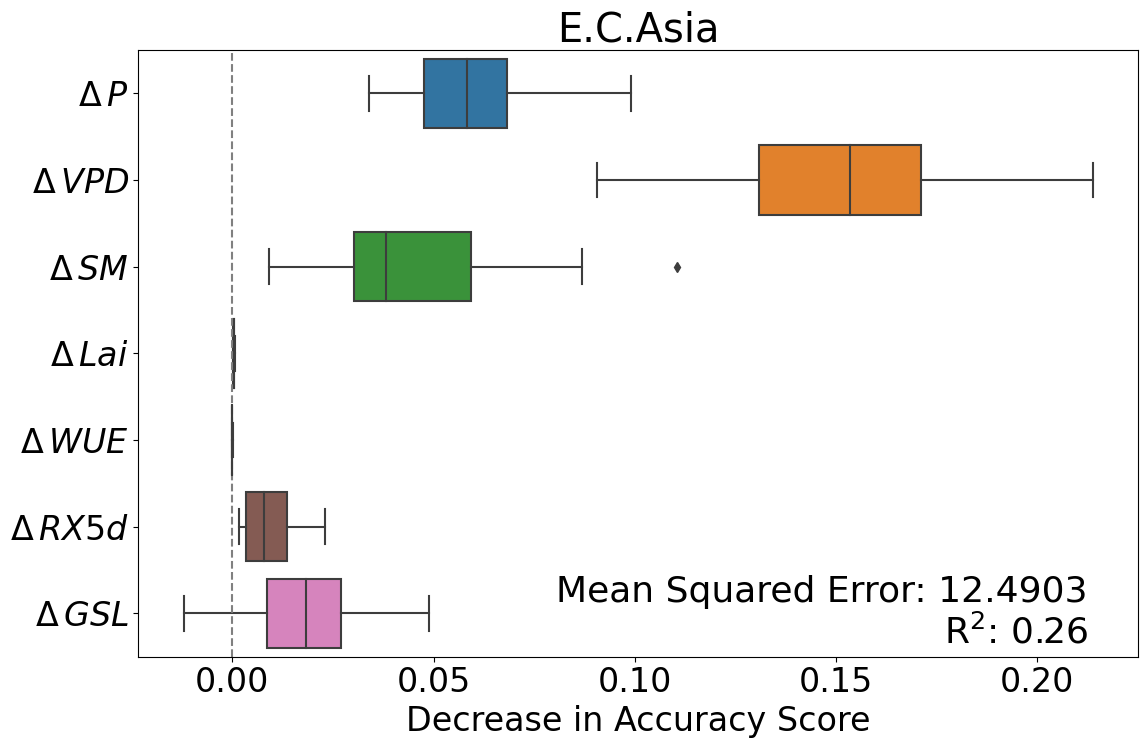

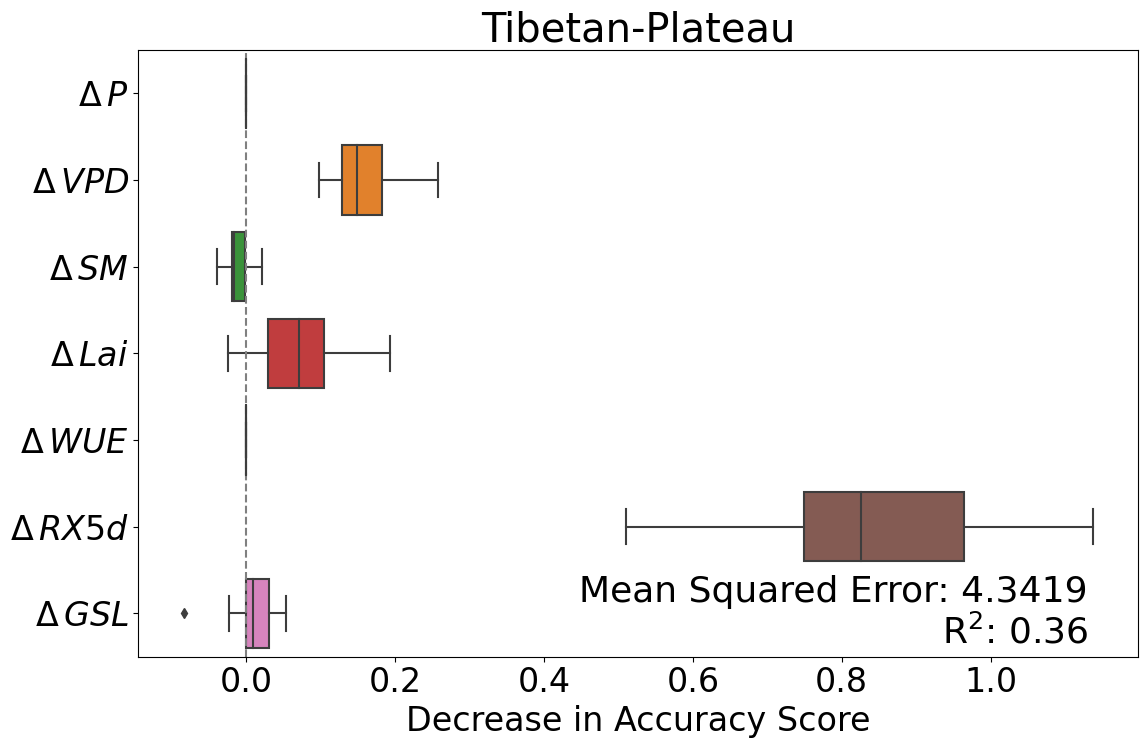

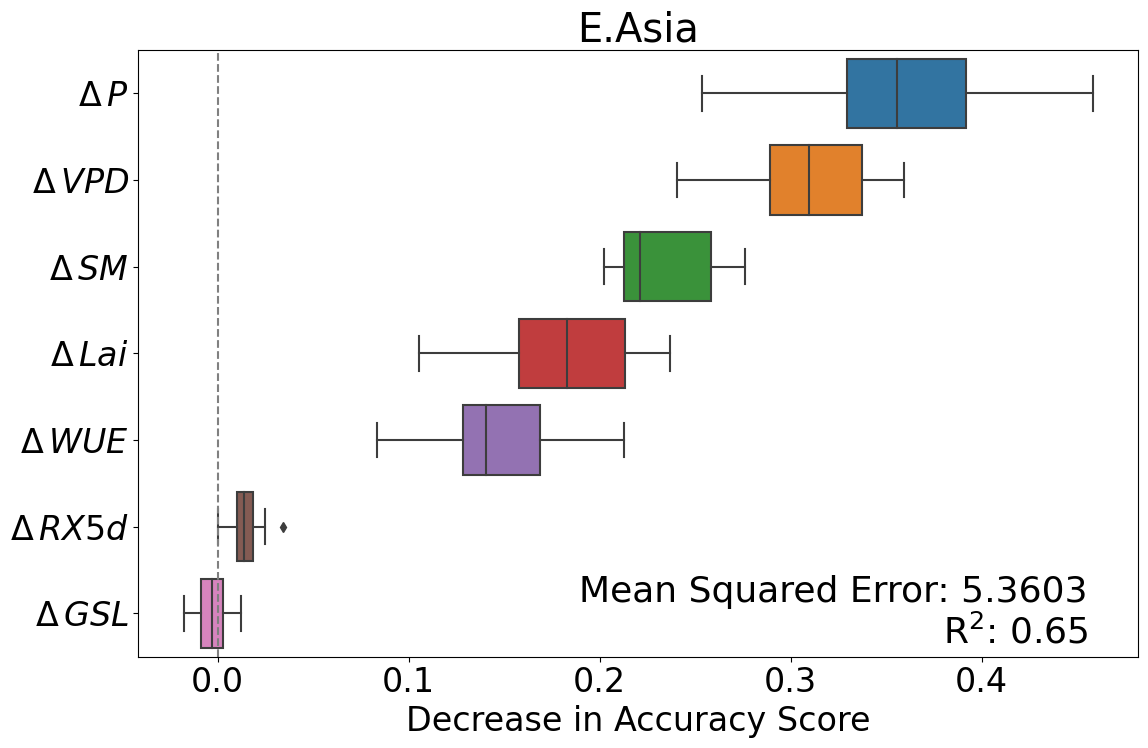

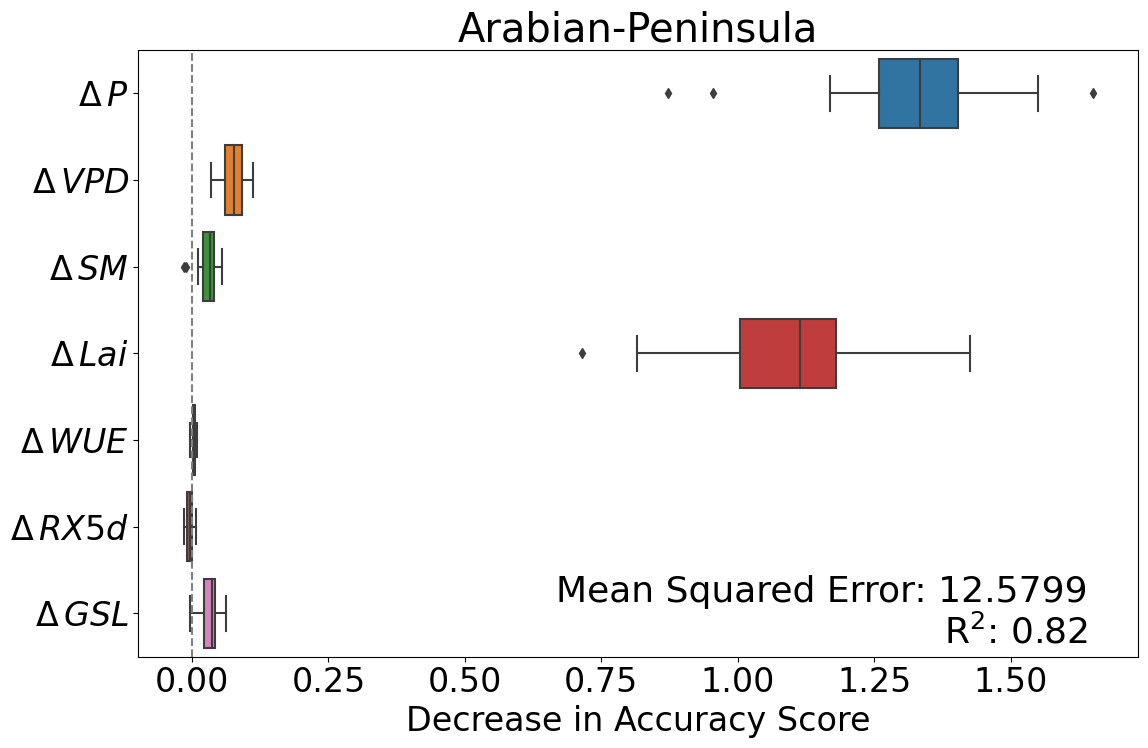

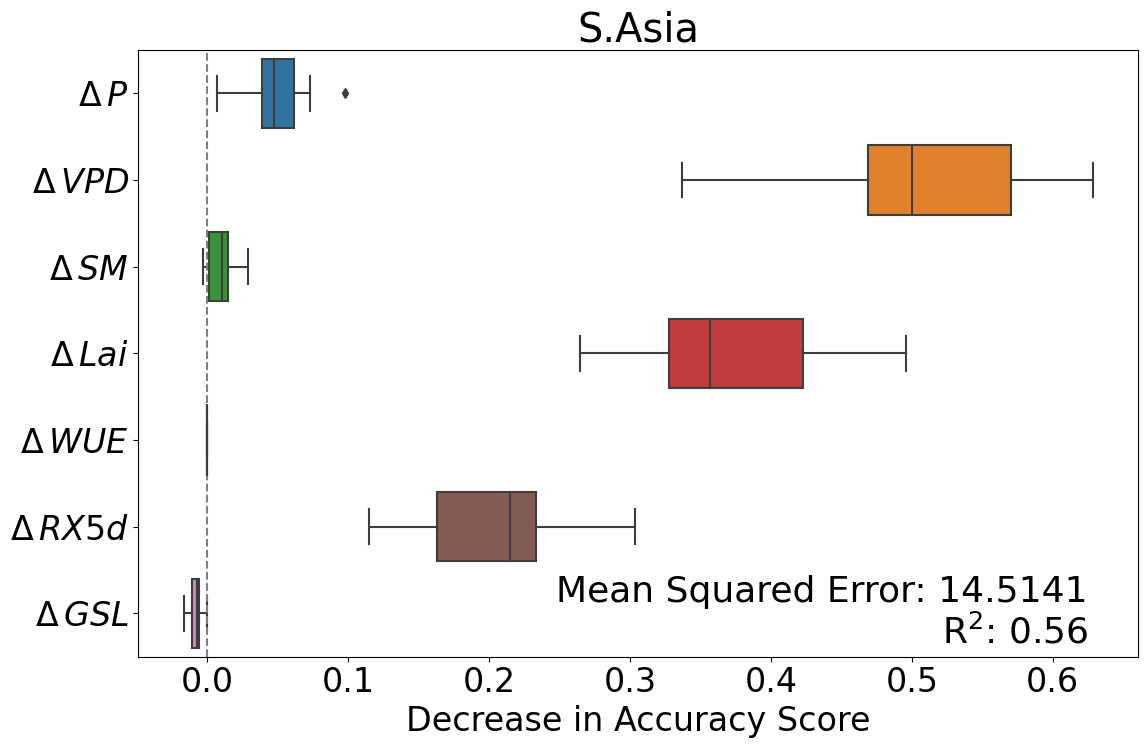

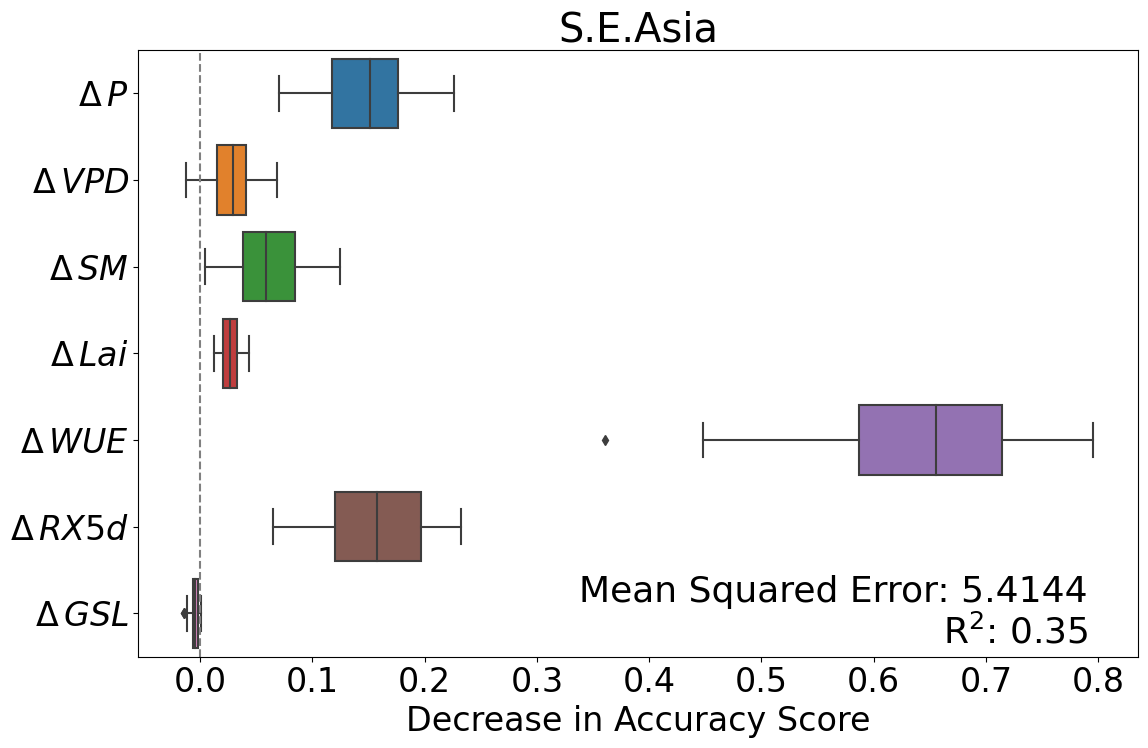

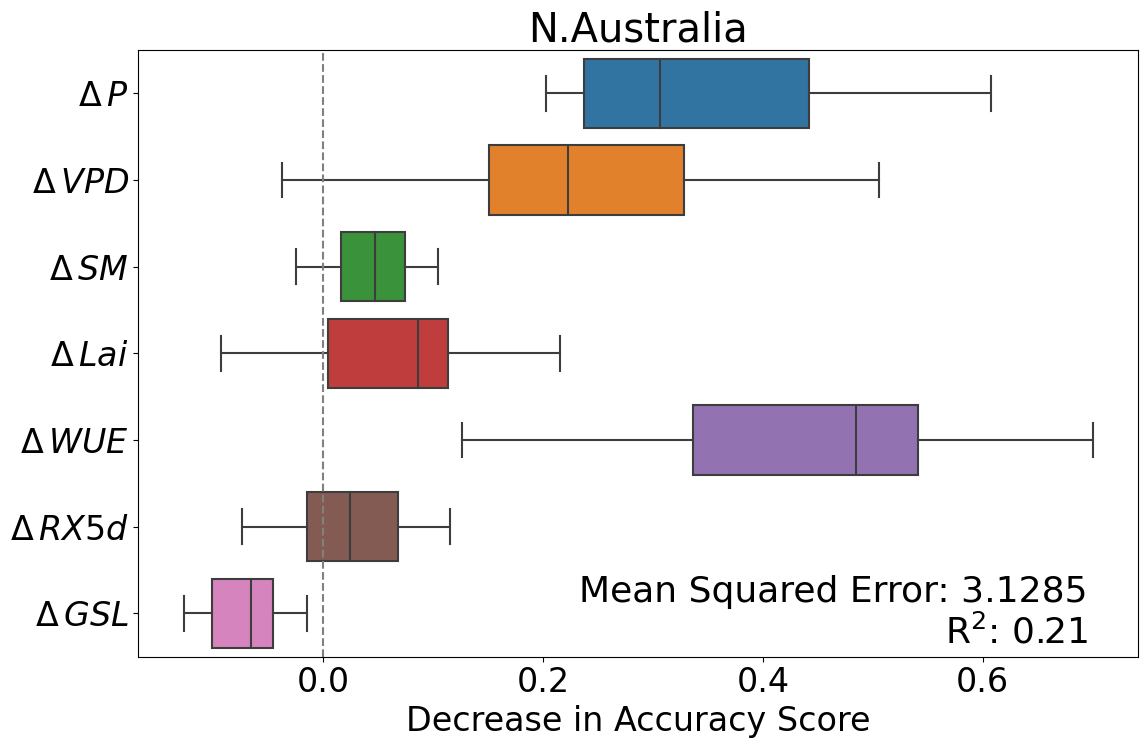

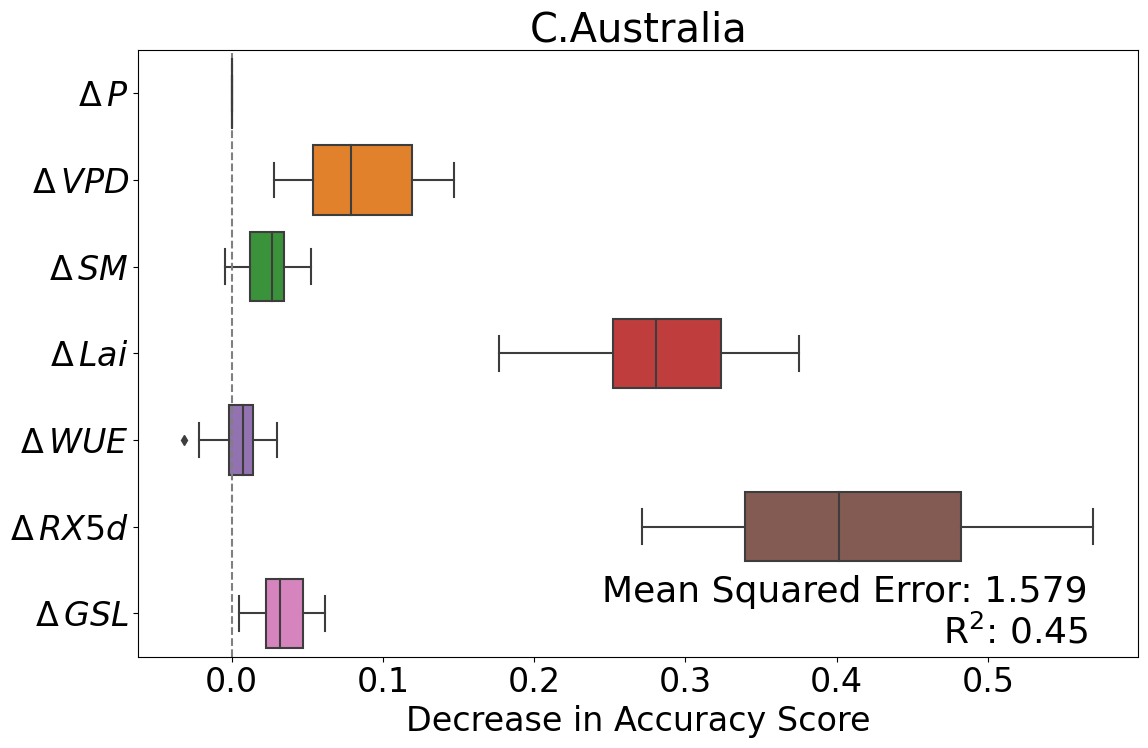

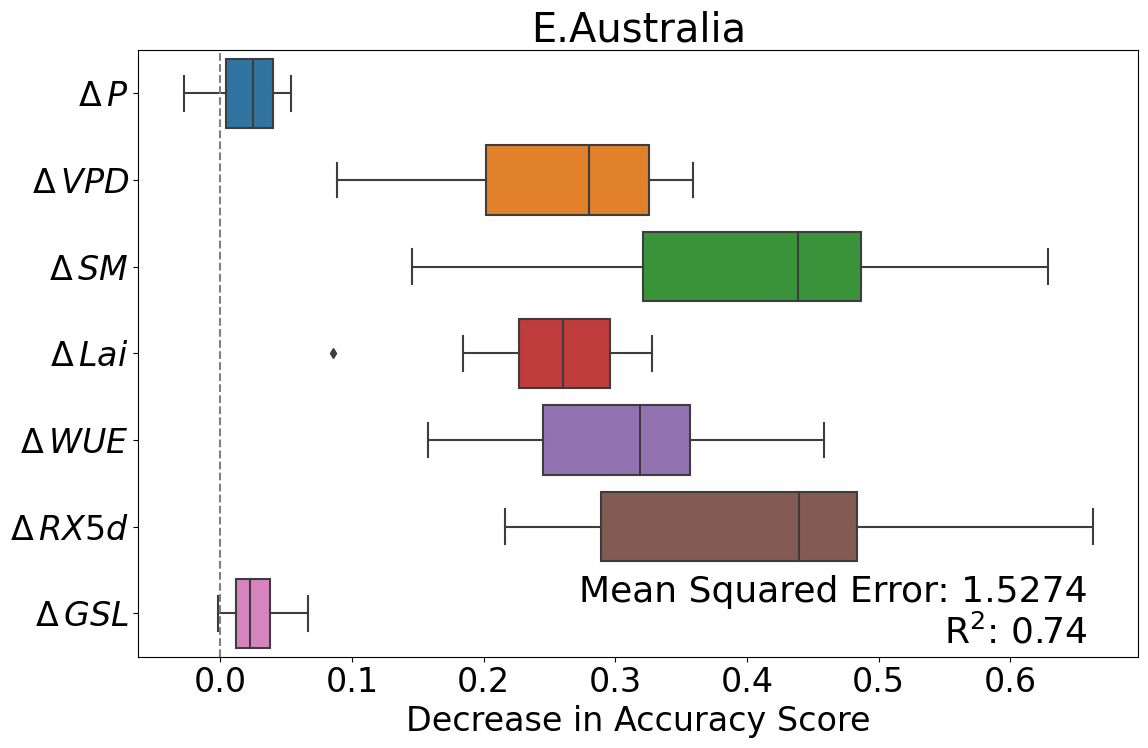

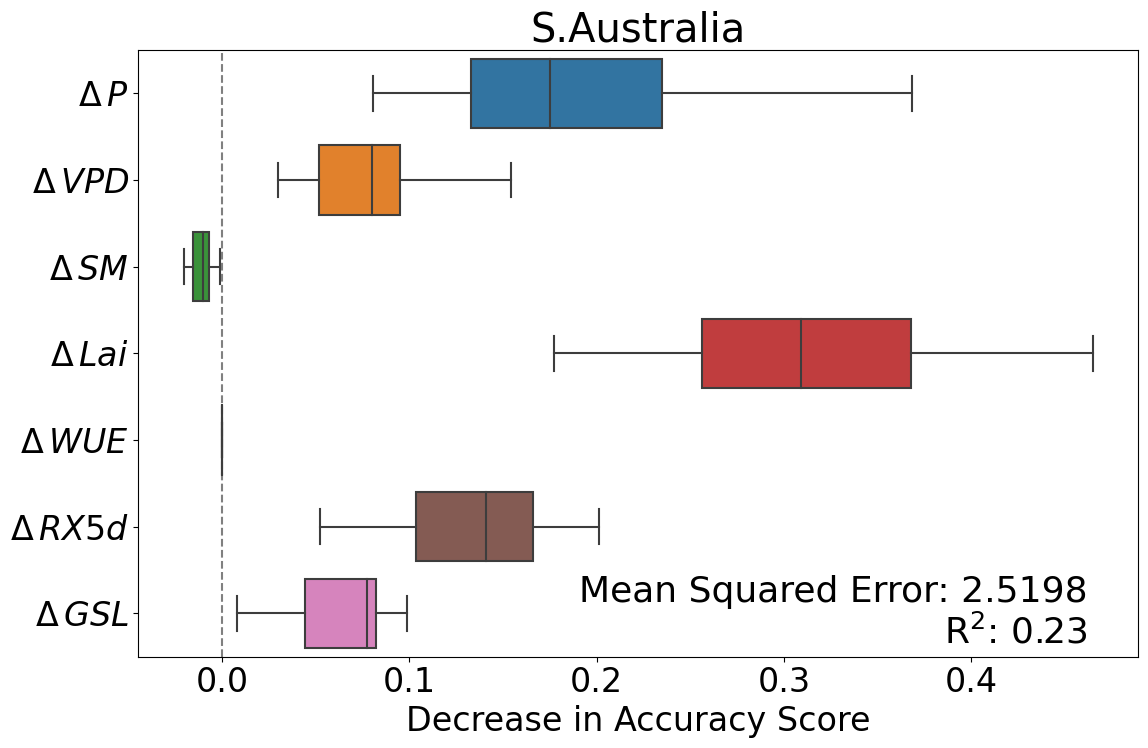

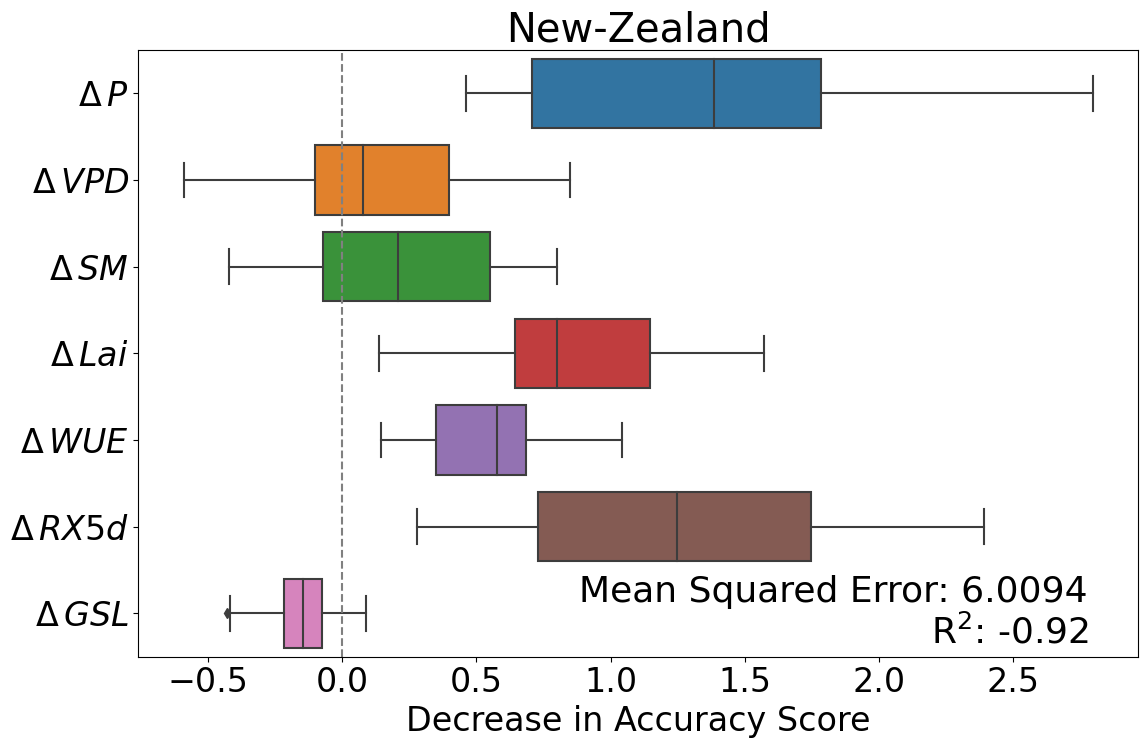

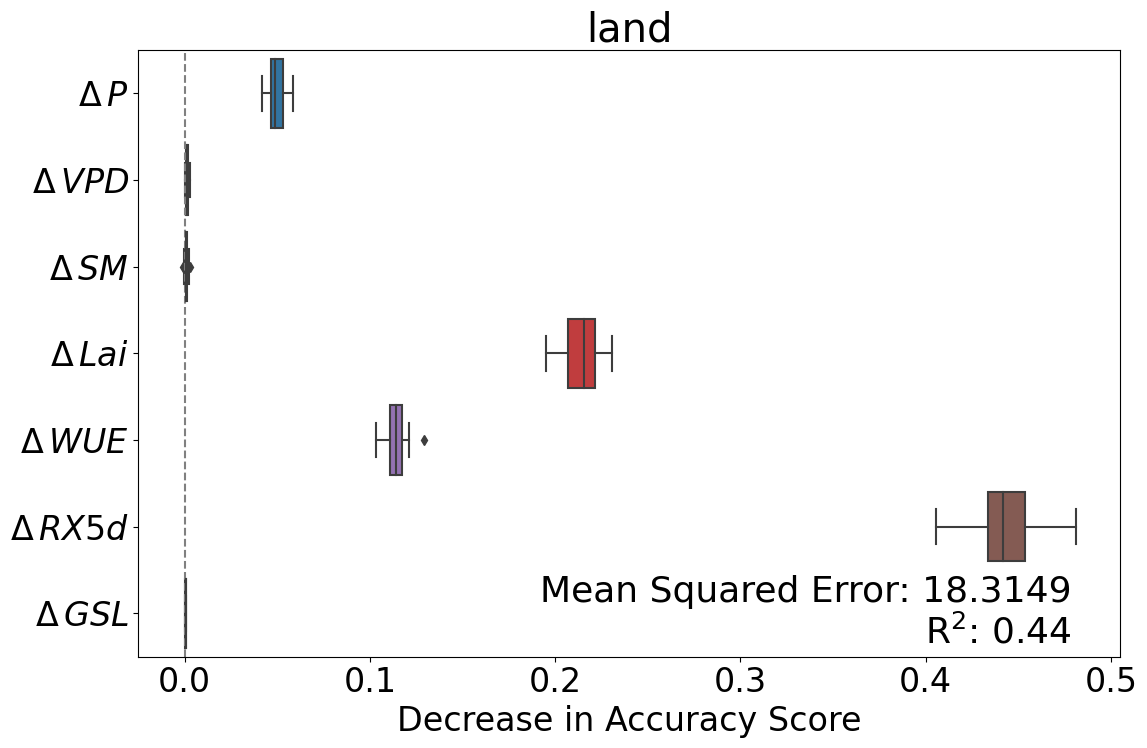

In [54]:
#plot_permutation_importances(permutation_importances_train_lr, predictor_vars, performance_metrics_train_lr, split='train', save_fig=False)
plot_permutation_importances(permutation_importances_test_lr, predictor_vars, performance_metrics_test_lr, split='test', save_fig=False)